TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal, entropy

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

## Creation de la base d'apprentissage

In [10]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [11]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [12]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [13]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [14]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [15]:
DEPTH_WAV = 3
NB_LABEL = 10

In [16]:
# Likelihood calculation (over z's, for given v, h and u)

def calc_lik(v,h,u):
    lik = np.zeros(10)
    for c in range(10):
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                lik[c] = rho[c][h][u]
            else:
                lik[c] = 1                
        else:
            if np.linalg.norm(mu[c][h][u]) > 1e-16:
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u], cov = Sigma[c][h][u] + 1e-10 * np.eye(3))
                lik[c] = (1-rho[c][h][u]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[c] = 0
        lik[c] = max(lik[c],1e-16)    
    return lik

In [17]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [18]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [111]:
#mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho-noisy-alt.pkl", "rb"))

In [20]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [21]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [22]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [23]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [24]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [25]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [26]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [27]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

In [28]:
h_max = 6
lik_predictive = {}
for c in range(10):
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            lik = calc_lik(v_predictive, h, u)
            lik_predictive[c][h][u] = lik

In [29]:
def predictive_search(z_ref, log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_ref][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, u_gen in enumerate(actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))  
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            if not FLAG_KL:
                FEP_post[i] = entropy(q_post) - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            else:
                FEP_post[i] = - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]) 
            #FEP_post[i] = - np.log(delta_q_post[z_ref]) #+ np.log(q_pre[c])
            #print u_gen, entropy(q_post), - np.log(delta_q_post[z_ref]), FEP_post[i] 
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_u[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [105]:
def FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(actions_set)
    batch_size = batch_ref * NB_LABEL
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_LABEL))
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                for c in range(NB_LABEL):
                    i_full = c * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[c][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    '''log_score_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        log_score_post_full += q_pre[c] * log_score_path[i_full]    #print q_pre'''
        
    for i, u_gen in enumerate(actions_set):
        for c in range(NB_LABEL):
            i_full = c * batch_ref + i
            q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
            if not FLAG_DUAL:
                FEP_post[i_full] = entropy(q_post)
                #print u_gen, q_post
                #print FEP_post[i]
            else:
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                #q_pre_hat = np.zeros(NB_LABEL)
                #q_pre_hat[c] = 1
                if not FLAG_KL:
                    FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[c]) + np.log(q_pre[c])
                else:
                    FEP_post[i_full] = - np.log(delta_q_post[c]) + np.log(q_pre[c])
                #FEP_post[i_full] = - np.log(delta_q_post[c]) #+ np.log(q_pre[c])
                #FEP_post[i_full] = entropy(q_post) + entropy(q_pre, delta_q_post)
                #print u_gen, entropy(q_post), - np.log(delta_q_post[c]), FEP_post[i_full] 
    #ch = raw_input('')    
    
    FEP_post_full = np.zeros((batch_ref,))
    for c in range(NB_LABEL):
        FEP_post_full += q_pre[c] * FEP_post[c * batch_ref : (c + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    
    ## 3 ##
    return dict_u[i_min]  #pi_path[i_max][z_ref]
    

In [31]:
def prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_KL = False):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde = predictive_search(z_tilde, log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [32]:
def FEP_prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = False, FLAG_FULL = False, FLAG_KL = False):
    
    ## 1 ##
    if not FLAG_FULL:
        u_tilde = FEP_predictive_search(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    else:
        u_tilde = FEP_predictive_search_full(log_score, actions_set, mem_h_u, FLAG_DUAL, FLAG_KL)
    
    return u_tilde

In [33]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [34]:
def generic_saliency_based_policy(H_predictive_sorted, mem_h_u):
    u_tilde = H_predictive_sorted.pop()[1]
    return u_tilde

In [35]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [36]:
def scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'predictive-dual' or POL == 'predictive-KL'\
    or POL == 'saliency-based' or POL == 'random' or POL == 'full' or POL == 'generic-saliency-based'\
    or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual' or POL == 'FEP-predictive-KL'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    if True : #POL == 'generic-saliency-based':
        H_predictive_sorted = calc_H_predictive_sorted(H_generic_eff)    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u)
        elif POL == 'predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True)
        elif POL == 'predictive-KL':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = prediction_based_policy(log_score, actions_set, mem_h_u, FLAG_DUAL = True, FLAG_KL = True)
            #print u_tilde
        elif POL == 'FEP-predictive-dual':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True)
            #print u_tilde
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = False, FLAG_FULL = True)
            #print u_tilde, H_predictive_sorted[-1]
        elif POL == 'FEP-predictive-KL':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = FEP_prediction_based_policy(log_score, actions_set, mem_h_u,\
                                                      FLAG_DUAL = True, FLAG_FULL = True, FLAG_KL = True)    
            #print u_tilde
            #ch = raw_input('')    
        elif POL == 'saliency-based':
            if TOUR == 0:
                u_tilde = H_predictive_sorted[-1][1]
            else:
                u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        elif POL == 'generic-saliency-based':
            u_tilde = generic_saliency_based_policy(H_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                lik = calc_lik(v, h_path, u_path)
                log_score[0] = update_log_score(log_score[0], lik)
                #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3  
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [37]:
from record import Record, affiche_records            

In [109]:
NB_TRIALS = 1000

In [71]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


    Policy : predictive, threshold : 0.03, 4 saccades, initial : 3, final : 7, classe : 7, elapsed time : 4.96038
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 0, final : 2, classe : 2, elapsed time : 9.72888
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 11.6165
    Policy : predictive, threshold : 0.03, 2 saccades, initial : 0, final : 0, classe : 0, elapsed time : 14.5421
    Policy : predictive, threshold : 0.03, 8 saccades, initial : 4, final : 4, classe : 4, elapsed time : 22.9571
    Policy : predictive, threshold : 0.03, 1 saccades, initial : 1, final : 1, classe : 1, elapsed time : 24.8637
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 7, final : 4, classe : 4, elapsed time : 28.7859
    Policy : predictive, threshold : 0.03, 4 saccades, initial : 8, final : 9, classe : 9, elapsed time : 33.8153
    Policy : predictive, threshold : 0.03, 10 saccades, initial : 2, final : 5, classe : 5, elapsed time : 44.5951
    Policy : predictive, threshold : 0.03, 3 saccades, initial : 0, final : 9, classe : 9, elapsed time : 48.4158

In [72]:
# Test generic saliency map

In [ ]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
file_name = "mnist-waveimage-records-FEP-dual-full-H0_init-noisy.npy"

if True : #not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive-dual', 'FEP-predictive'):#, 'FEP-predictive-KL', 'saliency-based', \
               # 'generic-saliency-based', 'random', 'predictive-KL', 'predictive-dual', 'predictive',): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        #for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        for THRESHOLD in (2, 1.5, 1, 7e-1, 5e-1, 3e-1, 2e-1, 1e-1):# 
        #for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2): #, 1e-5):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                #m_test = np.sum(x_test) 
                #x_noise =  x_test * .9  + .1 * ((1 - x_test) * np.random.rand(28 * 28))
                #x_noise = x_test * .9  + .1 * ((1 - x_test))
                #x_dim = x_test * .5
                #x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #x_noise = x_noise * np.random.binomial(1, x_noise) #+ np.random.binomial(1, x_noise) * np.random.rand(28 * 28) - .5
                #m_noise = np.sum(x_noise)
                # x_noise = x_noise * m_test / m_noise
                x_noise = np.copy(x_test)
                '''for _ in range(75):
                    i_1 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    i_2 = np.where(np.random.multinomial(1, np.ones(784)/784) == 1)[0][0]
                    x_noise[i_1], x_noise[i_2] = x_noise[i_2], x_noise[i_1]'''
                m_x = np.mean(x_test)
                x_noise = x_test * (1 - .4)  + .4 * (1 - x_test)
                x_noise = x_noise * np.random.rand(28 * 28) * np.random.binomial(1, x_noise)# + 0.1 * np.random.randn(28 * 28)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_noise , (1, 28*28)))
                          # 
                # initial
                log_score = np.zeros((1,10))
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                z_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''
                mem_h_u = []

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(wave_tensor_ref, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-dual', 2, 0)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 0.0179129
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.035645
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 4, classe : 1, elapsed time : 0.053808
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.0731659
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 0.090369
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 1, elapsed time : 0.107439
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 4, elapsed time : 0.124446
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 9, elapsed time : 0.141319
Policy : FEP-predictive-

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 1.4682
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 1.48812
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1.50917
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 1.52719
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1.54517
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 1.56341
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1.58259
('FEP-predictive-dual', 2, 80)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1.60082
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 2, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 3.04484
('FEP-predictive-dual', 2, 150)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 3.06707
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 3.0879
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 3.10755
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 5, elapsed time : 3.12612
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 3.14373
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 3.1607
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 3.1796
Policy : FEP-predictive-dual, thres

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 4.32975
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 4.34917
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 1, elapsed time : 4.36661
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 4.38319
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 8, elapsed time : 4.39973
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 4.41646
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 4.43395
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 7, elapsed time : 4.45015
('FEP-predictive-dual', 2, 230)
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5.62492
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 5.64243
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 5.66031
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 0, elapsed time : 5.67817
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 4, elapsed time : 5.69631
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.71345
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 5.72988
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 5.74786
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.88432
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 6.90262
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 6.91934
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 6.93617
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 6.95257
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.96922
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 6.98615
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 7.00301
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.69047
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.70845
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 8.72482
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 8.74235
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 8.75991
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 6, elapsed time : 8.77493
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 8.79151
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 8.80838
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 9.96574
('FEP-predictive-dual', 2, 510)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 9.99868
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 10.0244
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 10.0438
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 10.0614
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 10.0814
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 10.1084
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 10.1277
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 8, elapsed time : 11.4524
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 4, classe : 2, elapsed time : 11.4723
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 1, elapsed time : 11.4903
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 11.5069
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 11.5235
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 11.5397
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 5, elapsed time : 11.5562
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 4, elapsed time : 11.5739
('FEP-predictive-dual', 2, 590)
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 12.7037
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 12.7245
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 12.7428
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.7603
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 12.7773
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 12.7948
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 12.8124
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 12.8314
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.9789
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 13.998
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 1, elapsed time : 14.0163
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 7, elapsed time : 14.0341
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 14.0518
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 14.0698
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 14.0883
('FEP-predictive-dual', 2, 730)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 7, elapsed time : 14.1064
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 15.2557
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 15.2783
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 15.3006
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 15.3235
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 15.3397
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 15.3585
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 15.3755
('FEP-predictive-dual', 2, 800)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 15.3927
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 16.5139
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 16.5317
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 16.5489
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 16.5662
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 16.5845
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 16.6012
('FEP-predictive-dual', 2, 870)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 16.6184
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 16.6358
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 6, elapsed time : 18.2148
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 18.2362
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 18.2562
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 18.2746
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 18.2923
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 1, elapsed time : 18.3073
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 18.3257
('FEP-predictive-dual', 2, 950)
Policy : FEP-predictive-dual, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 18.3429
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 0.541433
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 6, classe : 9, elapsed time : 0.810666
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 0.956691
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 0.973845
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 1.2493
('FEP-predictive-dual', 1.5, 20)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 1.26647
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 6, elapsed time : 1.41613
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1.43291
Policy : FEP

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 2, classe : 8, elapsed time : 6.58764
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 6.73191
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 7, elapsed time : 6.75005
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6.76754
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 6.7844
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 1, elapsed time : 6.805
('FEP-predictive-dual', 1.5, 90)
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 6.94821
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 6.9668
Policy : FEP-predic

Policy : FEP-predictive-dual, threshold : 1.5, 4 saccades, initial : -1, final : 2, classe : 9, elapsed time : 12.5897
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.7297
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 5, elapsed time : 12.7468
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 12.7645
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 12.7818
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 12.8008
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 0, elapsed time : 12.8183
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 12.8352
Policy : FEP-predictive-dual, threshold : 1.5, 1

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 17.2902
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 17.434
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 17.4512
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 7, elapsed time : 17.4674
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 1, elapsed time : 17.6244
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 17.6416
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 17.6578
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 17.6747
Policy : FEP-predictive-dual, threshold : 1.5, 1 

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 4, classe : 8, elapsed time : 22.0712
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 22.0884
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 9, elapsed time : 22.3623
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 22.6338
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.6502
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 4, elapsed time : 22.6677
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.6849
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 22.7021
Policy : FEP-predictive-dual, threshold : 1.5, 1

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 28.1389
('FEP-predictive-dual', 1.5, 360)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 28.1565
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 28.1734
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 7, classe : 2, elapsed time : 28.4503
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 28.4682
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 28.6106
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 28.6273
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 6, elapsed time : 28.782
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 34.1169
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 1, elapsed time : 34.2587
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 4, elapsed time : 34.276
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 34.4314
('FEP-predictive-dual', 1.5, 430)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 34.4484
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 34.4653
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 34.4816
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 34.6227
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 5, classe : 9, elapsed time : 39.4237
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 39.4429
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 0, elapsed time : 39.4605
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 39.4776
('FEP-predictive-dual', 1.5, 500)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 39.4953
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 39.5121
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 5, elapsed time : 39.692
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 39.7112
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 44.7613
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 0, elapsed time : 44.9119
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 44.9275
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 44.9468
('FEP-predictive-dual', 1.5, 570)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 44.9648
Policy : FEP-predictive-dual, threshold : 1.5, 4 saccades, initial : -1, final : 6, classe : 4, elapsed time : 45.42
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 8, elapsed time : 45.4392
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 45.4578
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 49.8858
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 49.9044
Policy : FEP-predictive-dual, threshold : 1.5, 6 saccades, initial : -1, final : 7, classe : 5, elapsed time : 50.5364
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 9, elapsed time : 50.5547
('FEP-predictive-dual', 1.5, 640)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 50.5717
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 50.5897
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 50.6071
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 50.6245
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 55.8881
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 4, classe : 9, elapsed time : 56.1706
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 9, classe : 4, elapsed time : 56.4665
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 9, classe : 4, elapsed time : 56.6246
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 8, elapsed time : 56.7854
('FEP-predictive-dual', 1.5, 710)
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 56.8053
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 5, elapsed time : 56.8241
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 56.8424
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 63.2161
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 9, elapsed time : 63.2352
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 63.5382
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 0, classe : 2, elapsed time : 63.7117
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 63.8817
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 63.9008
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 63.9196
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 63.9386
('FEP-predictive-dual', 1.5, 780)
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 70.9685
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 70.9866
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 8, elapsed time : 71.0053
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 71.1967
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 4, classe : 7, elapsed time : 71.5268
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 71.5443
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 71.5621
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 3, elapsed time : 71.5815
('FEP-predictive-dual', 1.5, 850)
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 76.6341
Policy : FEP-predictive-dual, threshold : 1.5, 3 saccades, initial : -1, final : 3, classe : 9, elapsed time : 76.9351
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 8, elapsed time : 76.953
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 76.9707
Policy : FEP-predictive-dual, threshold : 1.5, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 77.4898
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 77.6366
Policy : FEP-predictive-dual, threshold : 1.5, 5 saccades, initial : -1, final : 7, classe : 1, elapsed time : 78.1457
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 78.1643
('FEP-predictive-dual', 1.5, 920)
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 83.8379
Policy : FEP-predictive-dual, threshold : 1.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 83.9956
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 3, elapsed time : 84.0136
Policy : FEP-predictive-dual, threshold : 1.5, 5 saccades, initial : -1, final : 5, classe : 8, elapsed time : 84.5259
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 84.5429
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 84.5593
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 6, elapsed time : 84.5769
Policy : FEP-predictive-dual, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 7, elapsed time : 84.5935
Policy : FEP-predictive-dual, threshold : 1.5, 1

Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 12.1086
('FEP-predictive-dual', 1, 50)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 12.1285
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 12.1472
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.4399
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 12.7391
Policy : FEP-predictive-dual, threshold : 1, 9 saccades, initial : -1, final : 8, classe : 6, elapsed time : 13.8079
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.8265
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 13.9867
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 1, 7 saccades, initial : -1, final : 6, classe : 9, elapsed time : 32.8173
Policy : FEP-predictive-dual, threshold : 1, 11 saccades, initial : -1, final : 9, classe : 2, elapsed time : 34.001
('FEP-predictive-dual', 1, 120)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 34.0189
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 34.0364
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 34.3204
Policy : FEP-predictive-dual, threshold : 1, 4 saccades, initial : -1, final : 8, classe : 6, elapsed time : 34.7273
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 34.8763
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 9, elapsed time : 35.1587
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 57.8572
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 57.8785
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 1, elapsed time : 58.056
('FEP-predictive-dual', 1, 190)
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 1, elapsed time : 58.4044
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 58.4313
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 58.7928
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 9, elapsed time : 59.0093
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 59.0306
Policy : FEP-predictive-dual, thr

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 2, elapsed time : 80.8485
Policy : FEP-predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 6, classe : 8, elapsed time : 81.6787
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 2, elapsed time : 81.859
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 82.035
('FEP-predictive-dual', 1, 260)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 82.0548
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 82.2076
Policy : FEP-predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 5, classe : 7, elapsed time : 82.877
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 7, elapsed time : 83.0332
Policy : FEP-predictive-dual, thres

Policy : FEP-predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 2, classe : 4, elapsed time : 107.212
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 107.591
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 107.613
Policy : FEP-predictive-dual, threshold : 1, 13 saccades, initial : -1, final : 8, classe : 7, elapsed time : 109.33
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 1, elapsed time : 109.912
('FEP-predictive-dual', 1, 330)
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 1, elapsed time : 110.075
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 110.093
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 110.264
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 129.812
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 129.83
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 129.848
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 130.124
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 130.271
('FEP-predictive-dual', 1, 400)
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 2, elapsed time : 130.423
Policy : FEP-predictive-dual, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 8, elapsed time : 130.814
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 6, classe : 3, elapsed time : 131.32
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 152.757
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 8, elapsed time : 152.91
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 153.082
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 153.099
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 153.12
('FEP-predictive-dual', 1, 470)
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 8, elapsed time : 153.297
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 0, classe : 9, elapsed time : 153.639
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 153.659
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 8 saccades, initial : -1, final : 5, classe : 6, elapsed time : 174.312
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 174.491
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 2, elapsed time : 174.642
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 174.926
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 175.085
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 175.105
('FEP-predictive-dual', 1, 540)
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 5, elapsed time : 175.265
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 175.419
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 3, classe : 8, elapsed time : 193.49
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 193.506
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 7, elapsed time : 193.653
Policy : FEP-predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 9, classe : 8, elapsed time : 194.292
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 6, elapsed time : 194.58
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 194.766
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 194.973
('FEP-predictive-dual', 1, 610)
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 195.002
Policy : FEP-predictive-dual, thre

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 215.781
Policy : FEP-predictive-dual, threshold : 1, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 216.615
Policy : FEP-predictive-dual, threshold : 1, 13 saccades, initial : -1, final : 3, classe : 5, elapsed time : 218.011
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 1, elapsed time : 218.311
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 218.33
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 218.626
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 9, elapsed time : 218.783
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 7, elapsed time : 218.802
('FEP-predictive-dual', 1, 680)
Policy : FEP-predictive-dual, th

Policy : FEP-predictive-dual, threshold : 1, 8 saccades, initial : -1, final : 8, classe : 2, elapsed time : 240.489
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 240.506
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 240.522
Policy : FEP-predictive-dual, threshold : 1, 13 saccades, initial : -1, final : 2, classe : 2, elapsed time : 242.1
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 1, elapsed time : 242.286
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 242.949
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 243.119
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 243.311
Policy : FEP-predictive-dual, threshold : 1, 12 saccades, initial

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 265.393
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 265.411
Policy : FEP-predictive-dual, threshold : 1, 15 saccades, initial : -1, final : 6, classe : 6, elapsed time : 267.289
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 267.848
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 267.999
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 268.016
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 5, classe : 1, elapsed time : 268.531
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 268.679
('FEP-predictive-dual', 1, 820)
Policy : FEP-predictive-dual, t

Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 289.268
Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 289.824
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 3, elapsed time : 290.101
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 0, elapsed time : 290.391
Policy : FEP-predictive-dual, threshold : 1, 3 saccades, initial : -1, final : 5, classe : 6, elapsed time : 290.689
Policy : FEP-predictive-dual, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 290.706
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 3, elapsed time : 290.862
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 291.02
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial 

Policy : FEP-predictive-dual, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 309.926
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 5, elapsed time : 310.11
Policy : FEP-predictive-dual, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 6, elapsed time : 310.516
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 4, elapsed time : 310.666
Policy : FEP-predictive-dual, threshold : 1, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 311.543
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 5, elapsed time : 311.708
Policy : FEP-predictive-dual, threshold : 1, 6 saccades, initial : -1, final : 3, classe : 1, elapsed time : 312.389
Policy : FEP-predictive-dual, threshold : 1, 9 saccades, initial : -1, final : 5, classe : 3, elapsed time : 313.348
Policy : FEP-predictive-dual, threshold : 1, 2 saccades, initial 

Policy : FEP-predictive-dual, threshold : 0.7, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 11.4345
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 11.7469
('FEP-predictive-dual', 0.7, 20)
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 11.7661
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 12.2028
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 6, elapsed time : 12.6296
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 12.7877
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 5, classe : 4, elapsed time : 13.1288
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 13.2906
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 8, classe : 7, elapsed time : 49.7975
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 50.0972
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 50.7612
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 5, classe : 1, elapsed time : 51.649
('FEP-predictive-dual', 0.7, 90)
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 8, classe : 3, elapsed time : 52.5482
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 53.1038
Policy : FEP-predictive-dual, threshold : 0.7, 10 saccades, initial : -1, final : 7, classe : 9, elapsed time : 54.257
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 0, classe : 3, elapsed time : 55.3276
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.7, 13 saccades, initial : -1, final : 5, classe : 5, elapsed time : 107.864
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 108.028
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 108.047
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 108.35
Policy : FEP-predictive-dual, threshold : 0.7, 15 saccades, initial : -1, final : 0, classe : 0, elapsed time : 110.015
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 110.549
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 111.089
('FEP-predictive-dual', 0.7, 160)
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 6, classe : 4, elapsed time : 111.877
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 9, classe : 7, elapsed time : 138.74
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 2, elapsed time : 138.898
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 0, classe : 2, elapsed time : 139.557
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 139.973
Policy : FEP-predictive-dual, threshold : 0.7, 14 saccades, initial : -1, final : 5, classe : 1, elapsed time : 141.506
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 2, elapsed time : 141.792
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 142.086
Policy : FEP-predictive-dual, threshold : 0.7, 16 saccades, initial : -1, final : 6, classe : 4, elapsed time : 143.855
Policy : FEP-predictive-dual, threshold : 0.7, 

Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 8, classe : 1, elapsed time : 182.011
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 182.442
('FEP-predictive-dual', 0.7, 290)
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 5, classe : 8, elapsed time : 182.988
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 2, classe : 2, elapsed time : 183.761
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 9, elapsed time : 184.055
Policy : FEP-predictive-dual, threshold : 0.7, 12 saccades, initial : -1, final : 2, classe : 2, elapsed time : 185.349
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 185.367
Policy : FEP-predictive-dual, threshold : 0.7, 10 saccades, initial : -1, final : 5, classe : 4, elapsed time : 186.492
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 7, classe : 5, elapsed time : 218.299
Policy : FEP-predictive-dual, threshold : 0.7, 10 saccades, initial : -1, final : 4, classe : 1, elapsed time : 219.419
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 5, classe : 7, elapsed time : 219.716
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 4, classe : 9, elapsed time : 219.877
('FEP-predictive-dual', 0.7, 360)
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 220.183
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 220.605
Policy : FEP-predictive-dual, threshold : 0.7, 14 saccades, initial : -1, final : 3, classe : 2, elapsed time : 222.144
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 222.569
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 257.256
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 257.414
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 257.58
Policy : FEP-predictive-dual, threshold : 0.7, 12 saccades, initial : -1, final : 5, classe : 9, elapsed time : 258.937
Policy : FEP-predictive-dual, threshold : 0.7, 9 saccades, initial : -1, final : 3, classe : 1, elapsed time : 259.941
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 259.959
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 2, classe : 8, elapsed time : 260.619
('FEP-predictive-dual', 0.7, 430)
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 1, elapsed time : 260.907
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 0, classe : 5, elapsed time : 295.699
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 295.716
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 296.007
Policy : FEP-predictive-dual, threshold : 0.7, 13 saccades, initial : -1, final : 7, classe : 7, elapsed time : 297.496
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 8, elapsed time : 297.683
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 4, classe : 9, elapsed time : 298.592
Policy : FEP-predictive-dual, threshold : 0.7, 9 saccades, initial : -1, final : 5, classe : 4, elapsed time : 299.593
Policy : FEP-predictive-dual, threshold : 0.7, 11 saccades, initial : -1, final : 4, classe : 0, elapsed time : 300.845
Policy : FEP-predictive-dual, threshold : 0.7,

Policy : FEP-predictive-dual, threshold : 0.7, 18 saccades, initial : -1, final : 9, classe : 9, elapsed time : 334.268
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 334.291
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 9, elapsed time : 334.735
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 5, classe : 8, elapsed time : 335.477
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 336.228
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 336.399
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 336.594
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 336.769
Policy : FEP-predictive-dual, threshold : 0.7, 

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 383.835
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 4, classe : 2, elapsed time : 384.684
('FEP-predictive-dual', 0.7, 630)
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 385.421
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 385.447
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 385.476
Policy : FEP-predictive-dual, threshold : 0.7, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 387.443
Policy : FEP-predictive-dual, threshold : 0.7, 26 saccades, initial : -1, final : 4, classe : 9, elapsed time : 390.247
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 390.513
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 7, classe : 1, elapsed time : 429.416
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 1, elapsed time : 429.69
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 5, classe : 4, elapsed time : 429.842
Policy : FEP-predictive-dual, threshold : 0.7, 13 saccades, initial : -1, final : 9, classe : 4, elapsed time : 431.172
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 1, classe : 3, elapsed time : 431.56
('FEP-predictive-dual', 0.7, 700)
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 8, classe : 1, elapsed time : 432.38
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 432.396
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 433.008
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.7, 9 saccades, initial : -1, final : 6, classe : 4, elapsed time : 475.74
Policy : FEP-predictive-dual, threshold : 0.7, 10 saccades, initial : -1, final : 2, classe : 0, elapsed time : 476.761
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 476.777
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 477.052
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 5, elapsed time : 477.321
Policy : FEP-predictive-dual, threshold : 0.7, 24 saccades, initial : -1, final : 5, classe : 1, elapsed time : 479.741
Policy : FEP-predictive-dual, threshold : 0.7, 6 saccades, initial : -1, final : 7, classe : 1, elapsed time : 480.351
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 8, classe : 6, elapsed time : 480.368
('FEP-predictive-dual', 0.7, 770)
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 518.249
Policy : FEP-predictive-dual, threshold : 0.7, 64 saccades, initial : -1, final : 6, classe : 1, elapsed time : 524.02
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 524.166
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 9, elapsed time : 524.319
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 3, classe : 6, elapsed time : 524.823
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 2, classe : 1, elapsed time : 525.331
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 1, classe : 1, elapsed time : 526.045
Policy : FEP-predictive-dual, threshold : 0.7, 15 saccades, initial : -1, final : 1, classe : 2, elapsed time : 527.56
Policy : FEP-predictive-dual, threshold : 0.7, 3

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 558.713
Policy : FEP-predictive-dual, threshold : 0.7, 14 saccades, initial : -1, final : 8, classe : 8, elapsed time : 560.231
('FEP-predictive-dual', 0.7, 900)
Policy : FEP-predictive-dual, threshold : 0.7, 5 saccades, initial : -1, final : 6, classe : 1, elapsed time : 560.725
Policy : FEP-predictive-dual, threshold : 0.7, 7 saccades, initial : -1, final : 5, classe : 4, elapsed time : 561.455
Policy : FEP-predictive-dual, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 4, elapsed time : 561.613
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 561.628
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 561.645
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 561.664
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 6, elapsed time : 597.157
Policy : FEP-predictive-dual, threshold : 0.7, 3 saccades, initial : -1, final : 7, classe : 9, elapsed time : 597.425
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 597.824
Policy : FEP-predictive-dual, threshold : 0.7, 8 saccades, initial : -1, final : 2, classe : 4, elapsed time : 598.653
Policy : FEP-predictive-dual, threshold : 0.7, 10 saccades, initial : -1, final : 6, classe : 4, elapsed time : 599.685
('FEP-predictive-dual', 0.7, 970)
Policy : FEP-predictive-dual, threshold : 0.7, 11 saccades, initial : -1, final : 4, classe : 5, elapsed time : 600.819
Policy : FEP-predictive-dual, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 601.21
Policy : FEP-predictive-dual, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 601.228
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 30.6575
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 4, elapsed time : 30.8095
Policy : FEP-predictive-dual, threshold : 0.5, 23 saccades, initial : -1, final : 7, classe : 7, elapsed time : 33.0846
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 2, elapsed time : 33.4657
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 2, classe : 7, elapsed time : 34.0675
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 34.3383
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 2, elapsed time : 34.9456
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 2, classe : 1, elapsed time : 35.4484
('FEP-predictive-dual', 0.5, 40)
Policy : FEP-p

Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 75.3166
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 75.4584
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 75.8469
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 4, elapsed time : 75.9873
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 9, elapsed time : 76.2688
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 6, classe : 9, elapsed time : 76.4122
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 76.4288
Policy : FEP-predictive-dual, threshold : 0.5, 9 saccades, initial : -1, final : 8, classe : 1, elapsed time : 77.3639
Policy : FEP-predictive-dual, threshold : 0.5, 3

Policy : FEP-predictive-dual, threshold : 0.5, 11 saccades, initial : -1, final : 5, classe : 1, elapsed time : 152.035
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 5, classe : 4, elapsed time : 152.645
('FEP-predictive-dual', 0.5, 170)
Policy : FEP-predictive-dual, threshold : 0.5, 13 saccades, initial : -1, final : 6, classe : 4, elapsed time : 153.993
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 8, classe : 7, elapsed time : 154.135
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 2, elapsed time : 154.411
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 4, classe : 3, elapsed time : 154.931
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 155.15
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 5, classe : 7, elapsed time : 155.502
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.5, 9 saccades, initial : -1, final : 5, classe : 9, elapsed time : 266.585
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 266.859
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 267.128
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 267.397
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 1, elapsed time : 267.79
('FEP-predictive-dual', 0.5, 240)
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 3, classe : 5, elapsed time : 267.933
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 4, classe : 9, elapsed time : 268.543
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 268.56
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.5, 14 saccades, initial : -1, final : 5, classe : 1, elapsed time : 312.161
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 312.986
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 8, classe : 4, elapsed time : 313.997
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 314.014
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 314.83
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 315.228
Policy : FEP-predictive-dual, threshold : 0.5, 27 saccades, initial : -1, final : 4, classe : 4, elapsed time : 317.872
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 3, elapsed time : 318.14
('FEP-predictive-dual', 0.5, 310)
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.5, 32 saccades, initial : -1, final : 5, classe : 3, elapsed time : 365.505
('FEP-predictive-dual', 0.5, 370)
Policy : FEP-predictive-dual, threshold : 0.5, 17 saccades, initial : -1, final : 7, classe : 7, elapsed time : 367.223
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 368.038
Policy : FEP-predictive-dual, threshold : 0.5, 18 saccades, initial : -1, final : 5, classe : 0, elapsed time : 369.853
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 369.995
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 371.033
Policy : FEP-predictive-dual, threshold : 0.5, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 372.157
Policy : FEP-predictive-dual, threshold : 0.5, 129 saccades, initial : -1, final : 5, classe : 4, elapsed time : 382.116
Policy 

Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 432.218
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 3, elapsed time : 432.605
Policy : FEP-predictive-dual, threshold : 0.5, 12 saccades, initial : -1, final : 7, classe : 7, elapsed time : 433.841
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 3, classe : 6, elapsed time : 434.859
('FEP-predictive-dual', 0.5, 440)
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 434.876
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 435.263
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 0, classe : 3, elapsed time : 435.878
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 0, elapsed time : 436.472
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 492.819
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 8, classe : 3, elapsed time : 493.851
Policy : FEP-predictive-dual, threshold : 0.5, 20 saccades, initial : -1, final : 2, classe : 1, elapsed time : 495.837
Policy : FEP-predictive-dual, threshold : 0.5, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 497.248
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 2, classe : 6, elapsed time : 497.849
Policy : FEP-predictive-dual, threshold : 0.5, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 499.745
('FEP-predictive-dual', 0.5, 510)
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 500.017
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 500.033
Policy : F

Policy : FEP-predictive-dual, threshold : 0.5, 7 saccades, initial : -1, final : 9, classe : 4, elapsed time : 556.186
Policy : FEP-predictive-dual, threshold : 0.5, 19 saccades, initial : -1, final : 5, classe : 8, elapsed time : 558.092
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 558.912
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 559.178
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 559.785
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 560.276
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 560.663
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 561.167
Policy : FEP-predictive-dual, threshold : 0.5, 

Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 3, classe : 9, elapsed time : 597.738
('FEP-predictive-dual', 0.5, 640)
Policy : FEP-predictive-dual, threshold : 0.5, 14 saccades, initial : -1, final : 5, classe : 1, elapsed time : 599.165
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 599.555
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 599.572
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 599.842
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 599.858
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 600.261
Policy : FEP-predictive-dual, threshold : 0.5, 13 saccades, initial : -1, final : 5, classe : 2, elapsed time : 601.594
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.5, 14 saccades, initial : -1, final : 9, classe : 9, elapsed time : 643.417
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 643.434
Policy : FEP-predictive-dual, threshold : 0.5, 11 saccades, initial : -1, final : 5, classe : 4, elapsed time : 644.585
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 645.084
('FEP-predictive-dual', 0.5, 710)
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 645.101
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 8, classe : 5, elapsed time : 645.118
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 5, classe : 4, elapsed time : 646.163
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 646.428
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.5, 22 saccades, initial : -1, final : 2, classe : 9, elapsed time : 714.744
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 5, classe : 4, elapsed time : 715.245
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 3, classe : 2, elapsed time : 716.06
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 716.2
Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 3, classe : 1, elapsed time : 717.012
Policy : FEP-predictive-dual, threshold : 0.5, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 718.923
Policy : FEP-predictive-dual, threshold : 0.5, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 719.856
('FEP-predictive-dual', 0.5, 780)
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 720.123
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.5, 8 saccades, initial : -1, final : 5, classe : 1, elapsed time : 772.071
Policy : FEP-predictive-dual, threshold : 0.5, 14 saccades, initial : -1, final : 7, classe : 7, elapsed time : 773.497
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 774.1
Policy : FEP-predictive-dual, threshold : 0.5, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 774.595
Policy : FEP-predictive-dual, threshold : 0.5, 35 saccades, initial : -1, final : 4, classe : 8, elapsed time : 777.939
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 777.956
Policy : FEP-predictive-dual, threshold : 0.5, 10 saccades, initial : -1, final : 5, classe : 7, elapsed time : 778.987
Policy : FEP-predictive-dual, threshold : 0.5, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 779.939
Policy : FEP-predictive-dual, threshold : 0.5, 

Policy : FEP-predictive-dual, threshold : 0.5, 17 saccades, initial : -1, final : 5, classe : 4, elapsed time : 844.23
Policy : FEP-predictive-dual, threshold : 0.5, 18 saccades, initial : -1, final : 0, classe : 7, elapsed time : 846.074
('FEP-predictive-dual', 0.5, 910)
Policy : FEP-predictive-dual, threshold : 0.5, 15 saccades, initial : -1, final : 5, classe : 4, elapsed time : 847.581
Policy : FEP-predictive-dual, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 847.597
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 847.871
Policy : FEP-predictive-dual, threshold : 0.5, 107 saccades, initial : -1, final : 4, classe : 9, elapsed time : 856.586
Policy : FEP-predictive-dual, threshold : 0.5, 61 saccades, initial : -1, final : 2, classe : 8, elapsed time : 862.123
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 862.264
Policy : 

Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 917.66
Policy : FEP-predictive-dual, threshold : 0.5, 94 saccades, initial : -1, final : 5, classe : 3, elapsed time : 925.51
Policy : FEP-predictive-dual, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 1, elapsed time : 925.894
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 926.038
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 6, classe : 1, elapsed time : 926.642
('FEP-predictive-dual', 0.5, 980)
Policy : FEP-predictive-dual, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 926.913
Policy : FEP-predictive-dual, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 927.056
Policy : FEP-predictive-dual, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 927.664
Policy : FEP-pr

Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 8, classe : 4, elapsed time : 74.4965
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 3, classe : 2, elapsed time : 75.5108
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 76.5245
Policy : FEP-predictive-dual, threshold : 0.3, 24 saccades, initial : -1, final : 5, classe : 5, elapsed time : 78.9624
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 79.2384
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 79.513
Policy : FEP-predictive-dual, threshold : 0.3, 16 saccades, initial : -1, final : 4, classe : 4, elapsed time : 81.1406
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 81.1557
('FEP-predictive-dual', 0.3, 50)
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 2, classe : 4, elapsed time : 177.954
('FEP-predictive-dual', 0.3, 110)
Policy : FEP-predictive-dual, threshold : 0.3, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 179.265
Policy : FEP-predictive-dual, threshold : 0.3, 11 saccades, initial : -1, final : 8, classe : 7, elapsed time : 180.373
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 5, classe : 3, elapsed time : 180.755
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 7, classe : 9, elapsed time : 181.248
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 2, classe : 7, elapsed time : 182.267
Policy : FEP-predictive-dual, threshold : 0.3, 9 saccades, initial : -1, final : 6, classe : 4, elapsed time : 183.18
Policy : FEP-predictive-dual, threshold : 0.3, 42 saccades, initial : -1, final : 4, classe : 4, elapsed time : 187.158
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.3, 50 saccades, initial : -1, final : 6, classe : 1, elapsed time : 326.419
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 327.433
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 1, elapsed time : 328.048
Policy : FEP-predictive-dual, threshold : 0.3, 26 saccades, initial : -1, final : 0, classe : 8, elapsed time : 330.589
('FEP-predictive-dual', 0.3, 180)
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 5, classe : 1, elapsed time : 330.974
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 3, classe : 8, elapsed time : 331.583
Policy : FEP-predictive-dual, threshold : 0.3, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 332.699
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 332.839
Policy : F

Policy : FEP-predictive-dual, threshold : 0.3, 9 saccades, initial : -1, final : 2, classe : 7, elapsed time : 462.702
Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 463.52
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 6, classe : 3, elapsed time : 464.131
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 464.273
Policy : FEP-predictive-dual, threshold : 0.3, 9 saccades, initial : -1, final : 6, classe : 4, elapsed time : 465.194
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 465.464
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 465.74
('FEP-predictive-dual', 0.3, 250)
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 9, classe : 4, elapsed time : 466.257
Policy : FEP-pre

Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 564.926
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 564.944
Policy : FEP-predictive-dual, threshold : 0.3, 55 saccades, initial : -1, final : 6, classe : 0, elapsed time : 570.078
Policy : FEP-predictive-dual, threshold : 0.3, 12 saccades, initial : -1, final : 5, classe : 3, elapsed time : 571.32
Policy : FEP-predictive-dual, threshold : 0.3, 25 saccades, initial : -1, final : 2, classe : 1, elapsed time : 573.775
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 573.792
Policy : FEP-predictive-dual, threshold : 0.3, 7 saccades, initial : -1, final : 5, classe : 6, elapsed time : 574.523
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 575.136
Policy : FEP-predictive-dual, threshold : 0.3,

Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 5, classe : 1, elapsed time : 719.697
Policy : FEP-predictive-dual, threshold : 0.3, 40 saccades, initial : -1, final : 5, classe : 1, elapsed time : 723.494
Policy : FEP-predictive-dual, threshold : 0.3, 11 saccades, initial : -1, final : 9, classe : 4, elapsed time : 724.621
('FEP-predictive-dual', 0.3, 380)
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 724.638
Policy : FEP-predictive-dual, threshold : 0.3, 9 saccades, initial : -1, final : 5, classe : 3, elapsed time : 725.579
Policy : FEP-predictive-dual, threshold : 0.3, 42 saccades, initial : -1, final : 3, classe : 3, elapsed time : 729.538
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 729.923
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 730.417
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 5, classe : 2, elapsed time : 839.365
Policy : FEP-predictive-dual, threshold : 0.3, 211 saccades, initial : -1, final : 2, classe : 6, elapsed time : 852.11
Policy : FEP-predictive-dual, threshold : 0.3, 15 saccades, initial : -1, final : 6, classe : 6, elapsed time : 853.623
Policy : FEP-predictive-dual, threshold : 0.3, 16 saccades, initial : -1, final : 2, classe : 4, elapsed time : 855.237
Policy : FEP-predictive-dual, threshold : 0.3, 12 saccades, initial : -1, final : 8, classe : 9, elapsed time : 856.443
Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 5, classe : 3, elapsed time : 857.246
('FEP-predictive-dual', 0.3, 450)
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 857.631
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 8, classe : 3, elapsed time : 858.124
Policy : F

Policy : FEP-predictive-dual, threshold : 0.3, 15 saccades, initial : -1, final : 2, classe : 4, elapsed time : 948.943
Policy : FEP-predictive-dual, threshold : 0.3, 21 saccades, initial : -1, final : 8, classe : 2, elapsed time : 951.036
Policy : FEP-predictive-dual, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 951.053
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 951.199
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 8, classe : 3, elapsed time : 952.243
Policy : FEP-predictive-dual, threshold : 0.3, 11 saccades, initial : -1, final : 5, classe : 2, elapsed time : 953.354
Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 954.163
Policy : FEP-predictive-dual, threshold : 0.3, 12 saccades, initial : -1, final : 5, classe : 5, elapsed time : 955.394
Policy : FEP-predictive-dual, threshold : 0

Policy : FEP-predictive-dual, threshold : 0.3, 11 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1072.19
Policy : FEP-predictive-dual, threshold : 0.3, 12 saccades, initial : -1, final : 5, classe : 7, elapsed time : 1073.45
('FEP-predictive-dual', 0.3, 580)
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1073.72
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1073.86
Policy : FEP-predictive-dual, threshold : 0.3, 27 saccades, initial : -1, final : 2, classe : 8, elapsed time : 1076.49
Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1077.29
Policy : FEP-predictive-dual, threshold : 0.3, 209 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1090.14
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1091.17
Policy :

Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1194.19
Policy : FEP-predictive-dual, threshold : 0.3, 17 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1195.89
Policy : FEP-predictive-dual, threshold : 0.3, 15 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1197.4
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1197.67
Policy : FEP-predictive-dual, threshold : 0.3, 30 saccades, initial : -1, final : 5, classe : 7, elapsed time : 1200.59
('FEP-predictive-dual', 0.3, 650)
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1200.86
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1201.24
Policy : FEP-predictive-dual, threshold : 0.3, 13 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1202.58
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.3, 29 saccades, initial : -1, final : 8, classe : 4, elapsed time : 1287.34
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1287.95
Policy : FEP-predictive-dual, threshold : 0.3, 256 saccades, initial : -1, final : 5, classe : 8, elapsed time : 1301.16
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1301.76
Policy : FEP-predictive-dual, threshold : 0.3, 36 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1305.24
Policy : FEP-predictive-dual, threshold : 0.3, 14 saccades, initial : -1, final : 5, classe : 0, elapsed time : 1306.64
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1307.67
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1307.94
('FEP-predictive-dual', 0.3, 720)
Policy :

Policy : FEP-predictive-dual, threshold : 0.3, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1448.21
('FEP-predictive-dual', 0.3, 780)
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1448.6
Policy : FEP-predictive-dual, threshold : 0.3, 19 saccades, initial : -1, final : 5, classe : 8, elapsed time : 1450.5
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1450.99
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1451.38
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 1451.87
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 5, elapsed time : 1452.01
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1452.16
Policy : FEP-

Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 7, elapsed time : 1558.03
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1558.3
Policy : FEP-predictive-dual, threshold : 0.3, 12 saccades, initial : -1, final : 8, classe : 1, elapsed time : 1559.55
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1560.57
('FEP-predictive-dual', 0.3, 850)
Policy : FEP-predictive-dual, threshold : 0.3, 13 saccades, initial : -1, final : 9, classe : 1, elapsed time : 1561.88
Policy : FEP-predictive-dual, threshold : 0.3, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1562.26
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 5, classe : 7, elapsed time : 1562.53
Policy : FEP-predictive-dual, threshold : 0.3, 9 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1563.45
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.3, 14 saccades, initial : -1, final : 6, classe : 9, elapsed time : 1666.51
Policy : FEP-predictive-dual, threshold : 0.3, 27 saccades, initial : -1, final : 2, classe : 8, elapsed time : 1669.14
Policy : FEP-predictive-dual, threshold : 0.3, 7 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1669.87
Policy : FEP-predictive-dual, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 1670.36
Policy : FEP-predictive-dual, threshold : 0.3, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1671.38
Policy : FEP-predictive-dual, threshold : 0.3, 31 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1674.38
Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1674.99
('FEP-predictive-dual', 0.3, 920)
Policy : FEP-predictive-dual, threshold : 0.3, 19 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1676.89
Policy : 

Policy : FEP-predictive-dual, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1789.15
Policy : FEP-predictive-dual, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1789.29
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1789.55
Policy : FEP-predictive-dual, threshold : 0.3, 8 saccades, initial : -1, final : 2, classe : 8, elapsed time : 1790.38
Policy : FEP-predictive-dual, threshold : 0.3, 29 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1793.21
Policy : FEP-predictive-dual, threshold : 0.3, 22 saccades, initial : -1, final : 3, classe : 2, elapsed time : 1795.4
Policy : FEP-predictive-dual, threshold : 0.3, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1795.66
Policy : FEP-predictive-dual, threshold : 0.3, 31 saccades, initial : -1, final : 5, classe : 7, elapsed time : 1798.69
Policy : FEP-predictive-dual, threshold : 0.3,

Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 2, elapsed time : 121.258
Policy : FEP-predictive-dual, threshold : 0.2, 7 saccades, initial : -1, final : 9, classe : 4, elapsed time : 121.968
Policy : FEP-predictive-dual, threshold : 0.2, 29 saccades, initial : -1, final : 4, classe : 4, elapsed time : 124.918
('FEP-predictive-dual', 0.2, 50)
Policy : FEP-predictive-dual, threshold : 0.2, 22 saccades, initial : -1, final : 9, classe : 6, elapsed time : 127.328
Policy : FEP-predictive-dual, threshold : 0.2, 39 saccades, initial : -1, final : 5, classe : 3, elapsed time : 131.166
Policy : FEP-predictive-dual, threshold : 0.2, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 131.552
Policy : FEP-predictive-dual, threshold : 0.2, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 133.085
Policy : FEP-predictive-dual, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 133.225
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.2, 20 saccades, initial : -1, final : 7, classe : 7, elapsed time : 338.846
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 6, classe : 4, elapsed time : 339.674
Policy : FEP-predictive-dual, threshold : 0.2, 66 saccades, initial : -1, final : 6, classe : 4, elapsed time : 345.857
Policy : FEP-predictive-dual, threshold : 0.2, 10 saccades, initial : -1, final : 4, classe : 4, elapsed time : 346.903
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 9, classe : 9, elapsed time : 360.411
Policy : FEP-predictive-dual, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 360.427
('FEP-predictive-dual', 0.2, 120)
Policy : FEP-predictive-dual, threshold : 0.2, 20 saccades, initial : -1, final : 5, classe : 5, elapsed time : 362.49
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 8, classe : 4, elapsed time : 363.311
Policy : 

Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 518.249
Policy : FEP-predictive-dual, threshold : 0.2, 53 saccades, initial : -1, final : 6, classe : 5, elapsed time : 523.248
Policy : FEP-predictive-dual, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 523.266
Policy : FEP-predictive-dual, threshold : 0.2, 135 saccades, initial : -1, final : 4, classe : 8, elapsed time : 534.241
Policy : FEP-predictive-dual, threshold : 0.2, 13 saccades, initial : -1, final : 9, classe : 9, elapsed time : 535.61
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 535.885
Policy : FEP-predictive-dual, threshold : 0.2, 10 saccades, initial : -1, final : 8, classe : 5, elapsed time : 536.92
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 537.847
Policy : FEP-predictive-dual, threshold : 0.2

Policy : FEP-predictive-dual, threshold : 0.2, 109 saccades, initial : -1, final : 7, classe : 2, elapsed time : 696.456
('FEP-predictive-dual', 0.2, 250)
Policy : FEP-predictive-dual, threshold : 0.2, 4 saccades, initial : -1, final : 5, classe : 4, elapsed time : 696.845
Policy : FEP-predictive-dual, threshold : 0.2, 238 saccades, initial : -1, final : 5, classe : 1, elapsed time : 710.503
Policy : FEP-predictive-dual, threshold : 0.2, 40 saccades, initial : -1, final : 4, classe : 9, elapsed time : 714.383
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 5, elapsed time : 715.345
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 715.657
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 5, classe : 7, elapsed time : 729.447
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 729.977
Policy 

Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 6, elapsed time : 917.988
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 4, classe : 5, elapsed time : 918.598
Policy : FEP-predictive-dual, threshold : 0.2, 14 saccades, initial : -1, final : 0, classe : 2, elapsed time : 920.16
Policy : FEP-predictive-dual, threshold : 0.2, 11 saccades, initial : -1, final : 6, classe : 5, elapsed time : 921.3
('FEP-predictive-dual', 0.2, 320)
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 5, classe : 9, elapsed time : 934.772
Policy : FEP-predictive-dual, threshold : 0.2, 11 saccades, initial : -1, final : 7, classe : 2, elapsed time : 935.895
Policy : FEP-predictive-dual, threshold : 0.2, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 936.622
Policy : FEP-predictive-dual, threshold : 0.2, 47 saccades, initial : -1, final : 3, classe : 3, elapsed time : 941.059
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1100.77
Policy : FEP-predictive-dual, threshold : 0.2, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1101.48
Policy : FEP-predictive-dual, threshold : 0.2, 115 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1110.77
Policy : FEP-predictive-dual, threshold : 0.2, 13 saccades, initial : -1, final : 3, classe : 6, elapsed time : 1112.11
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 2, elapsed time : 1113.05
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1113.97
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1127.48
('FEP-predictive-dual', 0.2, 390)
Policy : FEP-predictive-dual, threshold : 0.2, 41 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1131.5
Policy : 

Policy : FEP-predictive-dual, threshold : 0.2, 14 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1211.14
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 5, classe : 3, elapsed time : 1211.64
Policy : FEP-predictive-dual, threshold : 0.2, 21 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1213.75
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1214.36
Policy : FEP-predictive-dual, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 9, elapsed time : 1214.74
Policy : FEP-predictive-dual, threshold : 0.2, 27 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1217.46
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 3, classe : 2, elapsed time : 1218.06
Policy : FEP-predictive-dual, threshold : 0.2, 46 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1222.37
Policy : FEP-predictive-dual, threshold : 0.

Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1380.61
Policy : FEP-predictive-dual, threshold : 0.2, 11 saccades, initial : -1, final : 8, classe : 4, elapsed time : 1381.75
('FEP-predictive-dual', 0.2, 520)
Policy : FEP-predictive-dual, threshold : 0.2, 12 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1382.98
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1383.91
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 1384.41
Policy : FEP-predictive-dual, threshold : 0.2, 12 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1385.65
Policy : FEP-predictive-dual, threshold : 0.2, 7 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1386.36
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 5, classe : 0, elapsed time : 1386.87
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.2, 248 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1556.66
Policy : FEP-predictive-dual, threshold : 0.2, 15 saccades, initial : -1, final : 5, classe : 0, elapsed time : 1558.24
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1558.76
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 3, classe : 5, elapsed time : 1559.28
Policy : FEP-predictive-dual, threshold : 0.2, 67 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1565.41
('FEP-predictive-dual', 0.2, 590)
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1566.23
Policy : FEP-predictive-dual, threshold : 0.2, 29 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1569.08
Policy : FEP-predictive-dual, threshold : 0.2, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1569.47
Policy : 

Policy : FEP-predictive-dual, threshold : 0.2, 54 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1716.75
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1717.02
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1717.3
Policy : FEP-predictive-dual, threshold : 0.2, 13 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1718.71
Policy : FEP-predictive-dual, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1718.73
Policy : FEP-predictive-dual, threshold : 0.2, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1720.57
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 4, classe : 7, elapsed time : 1721.19
Policy : FEP-predictive-dual, threshold : 0.2, 15 saccades, initial : -1, final : 7, classe : 2, elapsed time : 1722.7
('FEP-predictive-dual', 0.2, 660)
Policy : FEP

Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1917.84
('FEP-predictive-dual', 0.2, 720)
Policy : FEP-predictive-dual, threshold : 0.2, 7 saccades, initial : -1, final : 3, classe : 5, elapsed time : 1918.53
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1919.39
Policy : FEP-predictive-dual, threshold : 0.2, 27 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1922.04
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 0, elapsed time : 1922.66
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1923.15
Policy : FEP-predictive-dual, threshold : 0.2, 25 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1925.63
Policy : FEP-predictive-dual, threshold : 0.2, 70 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1931.86
Policy : FE

Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 5, classe : 6, elapsed time : 2084.84
Policy : FEP-predictive-dual, threshold : 0.2, 5 saccades, initial : -1, final : 9, classe : 8, elapsed time : 2085.34
Policy : FEP-predictive-dual, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 2085.36
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 2086.17
('FEP-predictive-dual', 0.2, 790)
Policy : FEP-predictive-dual, threshold : 0.2, 45 saccades, initial : -1, final : 6, classe : 1, elapsed time : 2090.46
Policy : FEP-predictive-dual, threshold : 0.2, 35 saccades, initial : -1, final : 4, classe : 5, elapsed time : 2093.92
Policy : FEP-predictive-dual, threshold : 0.2, 16 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2095.53
Policy : FEP-predictive-dual, threshold : 0.2, 27 saccades, initial : -1, final : 8, classe : 8, elapsed time : 2098.18
Policy : F

Policy : FEP-predictive-dual, threshold : 0.2, 14 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2282.67
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2295.86
Policy : FEP-predictive-dual, threshold : 0.2, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2296.87
Policy : FEP-predictive-dual, threshold : 0.2, 211 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2309.75
Policy : FEP-predictive-dual, threshold : 0.2, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 2310.87
Policy : FEP-predictive-dual, threshold : 0.2, 6 saccades, initial : -1, final : 0, classe : 2, elapsed time : 2311.46
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 3, classe : 7, elapsed time : 2311.74
('FEP-predictive-dual', 0.2, 860)
Policy : FEP-predictive-dual, threshold : 0.2, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2311.88
Policy 

Policy : FEP-predictive-dual, threshold : 0.2, 44 saccades, initial : -1, final : 1, classe : 1, elapsed time : 2442.75
Policy : FEP-predictive-dual, threshold : 0.2, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2442.88
Policy : FEP-predictive-dual, threshold : 0.2, 30 saccades, initial : -1, final : 8, classe : 2, elapsed time : 2445.8
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2446.07
Policy : FEP-predictive-dual, threshold : 0.2, 25 saccades, initial : -1, final : 7, classe : 2, elapsed time : 2448.54
Policy : FEP-predictive-dual, threshold : 0.2, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2448.82
Policy : FEP-predictive-dual, threshold : 0.2, 67 saccades, initial : -1, final : 2, classe : 2, elapsed time : 2454.83
Policy : FEP-predictive-dual, threshold : 0.2, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2456.05
Policy : FEP-predictive-dual, threshold : 0.

Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 2631.51
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 5, classe : 1, elapsed time : 2644.83
Policy : FEP-predictive-dual, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 2644.97
('FEP-predictive-dual', 0.2, 990)
Policy : FEP-predictive-dual, threshold : 0.2, 8 saccades, initial : -1, final : 7, classe : 2, elapsed time : 2645.81
Policy : FEP-predictive-dual, threshold : 0.2, 9 saccades, initial : -1, final : 8, classe : 3, elapsed time : 2646.72
Policy : FEP-predictive-dual, threshold : 0.2, 14 saccades, initial : -1, final : 5, classe : 9, elapsed time : 2648.17
Policy : FEP-predictive-dual, threshold : 0.2, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2649.33
Policy : FEP-predictive-dual, threshold : 0.2, 256 saccades, initial : -1, final : 2, classe : 1, elapsed time : 2662.25
Policy :

Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 2, classe : 6, elapsed time : 185.524
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 185.793
Policy : FEP-predictive-dual, threshold : 0.1, 48 saccades, initial : -1, final : 5, classe : 4, elapsed time : 190.396
Policy : FEP-predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 7, classe : 1, elapsed time : 191.431
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 4, classe : 9, elapsed time : 192.376
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 194.143
('FEP-predictive-dual', 0.1, 60)
Policy : FEP-predictive-dual, threshold : 0.1, 34 saccades, initial : -1, final : 4, classe : 7, elapsed time : 197.517
Policy : FEP-predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 8, classe : 8, elapsed time : 199.091
Policy : 

Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 6, classe : 4, elapsed time : 454.328
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 3, classe : 7, elapsed time : 467.86
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 468.821
Policy : FEP-predictive-dual, threshold : 0.1, 26 saccades, initial : -1, final : 7, classe : 7, elapsed time : 471.468
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 2, classe : 9, elapsed time : 485.366
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 2, classe : 0, elapsed time : 486.297
Policy : FEP-predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 487.88
Policy : FEP-predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 488.917
Policy : FEP-predictive-dual, threshold : 

Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 1, elapsed time : 722.749
('FEP-predictive-dual', 0.1, 190)
Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 8, classe : 1, elapsed time : 724.836
Policy : FEP-predictive-dual, threshold : 0.1, 31 saccades, initial : -1, final : 4, classe : 1, elapsed time : 727.984
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 728.134
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 4, classe : 9, elapsed time : 741.596
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 741.614
Policy : FEP-predictive-dual, threshold : 0.1, 250 saccades, initial : -1, final : 2, classe : 3, elapsed time : 755.734
Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 8, classe : 1, elapsed time : 757.69
Policy

Policy : FEP-predictive-dual, threshold : 0.1, 25 saccades, initial : -1, final : 3, classe : 2, elapsed time : 1038.06
Policy : FEP-predictive-dual, threshold : 0.1, 12 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1039.87
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1040.28
Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 0, classe : 6, elapsed time : 1041.88
('FEP-predictive-dual', 0.1, 260)
Policy : FEP-predictive-dual, threshold : 0.1, 17 saccades, initial : -1, final : 5, classe : 8, elapsed time : 1043.86
Policy : FEP-predictive-dual, threshold : 0.1, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1044.72
Policy : FEP-predictive-dual, threshold : 0.1, 24 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1047.17
Policy : FEP-predictive-dual, threshold : 0.1, 24 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1049.63
Policy :

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1280.4
Policy : FEP-predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 5, classe : 0, elapsed time : 1281.97
Policy : FEP-predictive-dual, threshold : 0.1, 27 saccades, initial : -1, final : 0, classe : 4, elapsed time : 1284.73
Policy : FEP-predictive-dual, threshold : 0.1, 29 saccades, initial : -1, final : 8, classe : 2, elapsed time : 1287.65
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1287.67
Policy : FEP-predictive-dual, threshold : 0.1, 52 saccades, initial : -1, final : 8, classe : 7, elapsed time : 1292.67
Policy : FEP-predictive-dual, threshold : 0.1, 231 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1306.34
('FEP-predictive-dual', 0.1, 330)
Policy : FEP-predictive-dual, threshold : 0.1, 100 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1314.96
Policy 

Policy : FEP-predictive-dual, threshold : 0.1, 45 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1502.37
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1503.34
Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1505.58
Policy : FEP-predictive-dual, threshold : 0.1, 24 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1508.02
Policy : FEP-predictive-dual, threshold : 0.1, 66 saccades, initial : -1, final : 4, classe : 9, elapsed time : 1514.2
Policy : FEP-predictive-dual, threshold : 0.1, 15 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1515.78
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1516.41
Policy : FEP-predictive-dual, threshold : 0.1, 68 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1522.81
Policy : FEP-predictive-dual, threshold : 0

Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1775.19
Policy : FEP-predictive-dual, threshold : 0.1, 45 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1779.52
Policy : FEP-predictive-dual, threshold : 0.1, 23 saccades, initial : -1, final : 2, classe : 0, elapsed time : 1781.86
('FEP-predictive-dual', 0.1, 460)
Policy : FEP-predictive-dual, threshold : 0.1, 178 saccades, initial : -1, final : 9, classe : 5, elapsed time : 1794.04
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1795
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1795.62
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1796.13
Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1797.28
Policy : F

Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 3, elapsed time : 2112.6
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2112.87
Policy : FEP-predictive-dual, threshold : 0.1, 9 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2113.8
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 0, classe : 8, elapsed time : 2114.55
Policy : FEP-predictive-dual, threshold : 0.1, 28 saccades, initial : -1, final : 6, classe : 3, elapsed time : 2117.42
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 1, elapsed time : 2130.99
('FEP-predictive-dual', 0.1, 530)
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 2, classe : 9, elapsed time : 2144.68
Policy : FEP-predictive-dual, threshold : 0.1, 71 saccades, initial : -1, final : 2, classe : 3, elapsed time : 2151.21
Policy : F

Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 2, classe : 8, elapsed time : 2437.31
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2437.45
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 7, classe : 9, elapsed time : 2450.98
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 2, classe : 6, elapsed time : 2464.32
Policy : FEP-predictive-dual, threshold : 0.1, 12 saccades, initial : -1, final : 3, classe : 3, elapsed time : 2465.56
Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 5, classe : 8, elapsed time : 2467.49
Policy : FEP-predictive-dual, threshold : 0.1, 49 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2472.14
Policy : FEP-predictive-dual, threshold : 0.1, 23 saccades, initial : -1, final : 5, classe : 9, elapsed time : 2474.45
Policy : FEP-predictive-dual, threshol

Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 0, classe : 7, elapsed time : 2726.12
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 8, classe : 2, elapsed time : 2739.39
('FEP-predictive-dual', 0.1, 660)
Policy : FEP-predictive-dual, threshold : 0.1, 24 saccades, initial : -1, final : 2, classe : 4, elapsed time : 2741.9
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 2, classe : 0, elapsed time : 2742.61
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2743.33
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 3, classe : 1, elapsed time : 2756.83
Policy : FEP-predictive-dual, threshold : 0.1, 88 saccades, initial : -1, final : 2, classe : 8, elapsed time : 2764.51
Policy : FEP-predictive-dual, threshold : 0.1, 16 saccades, initial : -1, final : 6, classe : 6, elapsed time : 2766.15
Policy 

Policy : FEP-predictive-dual, threshold : 0.1, 209 saccades, initial : -1, final : 2, classe : 1, elapsed time : 3001.6
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 3, classe : 7, elapsed time : 3001.98
Policy : FEP-predictive-dual, threshold : 0.1, 67 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3008.09
Policy : FEP-predictive-dual, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3008.36
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 2, classe : 6, elapsed time : 3008.97
('FEP-predictive-dual', 0.1, 730)
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 7, elapsed time : 3009.11
Policy : FEP-predictive-dual, threshold : 0.1, 213 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3022.47
Policy : FEP-predictive-dual, threshold : 0.1, 48 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3027.14
Policy : 

Policy : FEP-predictive-dual, threshold : 0.1, 16 saccades, initial : -1, final : 5, classe : 3, elapsed time : 3329.29
Policy : FEP-predictive-dual, threshold : 0.1, 6 saccades, initial : -1, final : 5, classe : 8, elapsed time : 3329.91
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3330.05
Policy : FEP-predictive-dual, threshold : 0.1, 49 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3334.68
Policy : FEP-predictive-dual, threshold : 0.1, 13 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3336.01
Policy : FEP-predictive-dual, threshold : 0.1, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 3337.19
Policy : FEP-predictive-dual, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 1, elapsed time : 3337.64
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3338.22
('FEP-predictive-dual', 0.1, 800)
Policy : F

Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 3, classe : 7, elapsed time : 3612.32
('FEP-predictive-dual', 0.1, 860)
Policy : FEP-predictive-dual, threshold : 0.1, 7 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3613.08
Policy : FEP-predictive-dual, threshold : 0.1, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 3614.17
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 9, classe : 9, elapsed time : 3628.46
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 4, classe : 2, elapsed time : 3629
Policy : FEP-predictive-dual, threshold : 0.1, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 3629.55
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3631.51
Policy : FEP-predictive-dual, threshold : 0.1, 69 saccades, initial : -1, final : 5, classe : 5, elapsed time : 3638.21
Policy : F

Policy : FEP-predictive-dual, threshold : 0.1, 252 saccades, initial : -1, final : 3, classe : 2, elapsed time : 3888.54
Policy : FEP-predictive-dual, threshold : 0.1, 45 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3893.17
Policy : FEP-predictive-dual, threshold : 0.1, 25 saccades, initial : -1, final : 4, classe : 9, elapsed time : 3895.94
Policy : FEP-predictive-dual, threshold : 0.1, 19 saccades, initial : -1, final : 5, classe : 1, elapsed time : 3898.02
('FEP-predictive-dual', 0.1, 930)
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 7, elapsed time : 3912.26
Policy : FEP-predictive-dual, threshold : 0.1, 256 saccades, initial : -1, final : 4, classe : 4, elapsed time : 3926.97
Policy : FEP-predictive-dual, threshold : 0.1, 18 saccades, initial : -1, final : 3, classe : 0, elapsed time : 3928.97
Policy : FEP-predictive-dual, threshold : 0.1, 20 saccades, initial : -1, final : 3, classe : 3, elapsed time : 3931.13
Pol

Policy : FEP-predictive-dual, threshold : 0.1, 22 saccades, initial : -1, final : 3, classe : 1, elapsed time : 4176.91
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 4176.93
Policy : FEP-predictive-dual, threshold : 0.1, 25 saccades, initial : -1, final : 2, classe : 2, elapsed time : 4179.65
Policy : FEP-predictive-dual, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 4179.66
Policy : FEP-predictive-dual, threshold : 0.1, 21 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4181.94
Policy : FEP-predictive-dual, threshold : 0.1, 28 saccades, initial : -1, final : 4, classe : 9, elapsed time : 4184.97


Nb trials : 1000000


('FEP-predictive', 2, 0)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 0.018527
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 0.0370922
Policy

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 6, elapsed time : 1.32508
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1.34435
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1.36259
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.38085
('FEP-predictive', 2, 70)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1.39976
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.42194
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 1.43954
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 1.45755
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, c

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 2.94981
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 2.9686
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 2.98685
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 7, elapsed time : 3.00263
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 1, elapsed time : 3.02205
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 8, elapsed time : 3.0403
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 3.05803
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 3.07552
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 3.

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 4.45303
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 7, elapsed time : 4.47134
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 4.48956
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 4.50756
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 4.52577
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 4.54439
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 1, elapsed time : 4.562
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 4.57927
('FEP-predictive', 2, 230)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, cl

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 5.93411
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 5.95293
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 5.97133
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 2, elapsed time : 5.98943
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 6.0084
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 4, elapsed time : 6.02601
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 6.04374
('FEP-predictive', 2, 310)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 6.06123
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, c

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 7.3904
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 7.41368
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 7.43236
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 1, elapsed time : 7.4514
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 7.47037
('FEP-predictive', 2, 380)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 7.48912
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 7.50762
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 3, elapsed time : 7.52608
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, cl

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 8.94458
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 8.9625
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 8.98052
('FEP-predictive', 2, 450)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 3, elapsed time : 8.99606
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 9.0135
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 9.0324
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 9.05072
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 9, elapsed time : 9.06932
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, cla

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 7, elapsed time : 10.4366
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 10.4613
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 10.4791
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.4969
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 10.5149
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 10.5334
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 10.5516
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 10.5695
('FEP-predictive', 2, 530)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, 

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 11.8851
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 11.9089
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 6, elapsed time : 11.9267
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 11.9452
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 11.9633
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 11.9817
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 12.0003
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 12.0187
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 13.3685
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 7, elapsed time : 13.3894
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 13.412
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 13.4282
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 7, elapsed time : 13.4459
('FEP-predictive', 2, 680)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 13.4639
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 13.4796
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 13.4975
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, c

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 4, elapsed time : 14.8696
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 14.8891
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 14.9066
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 14.9257
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 7, elapsed time : 14.9449
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 14.9634
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 9, elapsed time : 14.9823
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 15.0005
('FEP-predictive', 2, 760)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, 

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 16.3251
('FEP-predictive', 2, 830)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 16.3451
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 16.3641
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 7, elapsed time : 16.3844
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 9, elapsed time : 16.4047
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 16.4239
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 16.442
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 1, elapsed time : 16.4598
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, c

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 4, classe : 7, elapsed time : 17.7972
('FEP-predictive', 2, 910)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 17.8155
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 17.8329
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 17.8482
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 9, elapsed time : 17.8663
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 5, classe : 8, elapsed time : 17.884
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 17.9035
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 17.9216
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, c

Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 19.2569
('FEP-predictive', 2, 990)
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 19.277
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 19.2948
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 19.3105
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 19.3284
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 19.3468
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 19.3631
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 19.3827
Policy : FEP-predictive, threshold : 2, 1 saccades, initial : -1, final : 0, c

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 9, elapsed time : 6.39416
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 3, elapsed time : 6.41364
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 6.43285
Policy : FEP-predictive, threshold : 1.5, 4 saccades, initial : -1, final : 3, classe : 4, elapsed time : 6.78484
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 6.80387
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 6.82198
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 6.84026
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 0, elapsed time : 6.85814
('FEP-predictive', 1.5, 70)
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initia

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 11.5018
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 11.632
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 11.651
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 1, elapsed time : 11.6708
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 11.6892
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 11.8182
('FEP-predictive', 1.5, 140)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 11.8361
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 7, elapsed time : 11.8536
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 9, elapsed time : 16.3518
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 16.3705
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 16.3872
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 9, elapsed time : 16.5163
('FEP-predictive', 1.5, 210)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 4, classe : 4, elapsed time : 16.5344
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 16.6664
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 9, elapsed time : 16.7956
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 3, elapsed time : 16.93
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial

Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 22.199
('FEP-predictive', 1.5, 280)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 22.2183
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 2, classe : 9, elapsed time : 22.3455
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 22.3635
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 22.3818
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 22.3992
Policy : FEP-predictive, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 22.6433
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 2, classe : 6, elapsed time : 22.7766
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initia

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 26.4998
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 9, elapsed time : 26.5199
('FEP-predictive', 1.5, 360)
Policy : FEP-predictive, threshold : 1.5, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 26.7659
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 26.7838
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 26.8014
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 26.821
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 26.8396
Policy : FEP-predictive, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 0, elapsed time : 27.077
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 1, elapsed time : 31.7337
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 31.7521
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 4, elapsed time : 31.7702
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 31.9014
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 31.9202
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 8, elapsed time : 32.0508
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 8, elapsed time : 32.069
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 32.0863
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 7

Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 36.4098
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 36.5428
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 3, elapsed time : 36.5588
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 1, elapsed time : 36.5772
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.5961
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 6, elapsed time : 36.733
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 36.7526
('FEP-predictive', 1.5, 510)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 36.7709
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initia

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 3, elapsed time : 41.2057
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 9, elapsed time : 41.2243
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 41.2421
Policy : FEP-predictive, threshold : 1.5, 4 saccades, initial : -1, final : 9, classe : 3, elapsed time : 41.5858
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 41.6034
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 8, classe : 7, elapsed time : 41.7327
('FEP-predictive', 1.5, 580)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 8, elapsed time : 41.7515
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 41.7699
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initi

Policy : FEP-predictive, threshold : 1.5, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 46.7617
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 1, elapsed time : 46.7803
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 46.7983
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 7, elapsed time : 46.9287
('FEP-predictive', 1.5, 650)
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 47.0678
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 7, elapsed time : 47.0864
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 3, classe : 1, elapsed time : 47.1047
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 47.1225
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initi

Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 0, elapsed time : 50.8293
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 50.9631
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 50.9817
('FEP-predictive', 1.5, 720)
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 5, elapsed time : 51.1192
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 51.1384
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 4, elapsed time : 51.1562
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 51.2906
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 51.3106
Policy : FEP-predictive, threshold : 1.5, 3 saccades, initi

Policy : FEP-predictive, threshold : 1.5, 3 saccades, initial : -1, final : 9, classe : 4, elapsed time : 56.544
('FEP-predictive', 1.5, 790)
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 5, classe : 1, elapsed time : 56.6709
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 56.6884
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 8, classe : 3, elapsed time : 56.7059
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 56.8378
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 56.857
Policy : FEP-predictive, threshold : 1.5, 5 saccades, initial : -1, final : 5, classe : 3, elapsed time : 57.2934
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 57.3119
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial

Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 60.8519
Policy : FEP-predictive, threshold : 1.5, 5 saccades, initial : -1, final : 6, classe : 3, elapsed time : 61.3016
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 5, elapsed time : 61.3197
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 2, classe : 2, elapsed time : 61.3378
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 61.3559
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 61.3735
('FEP-predictive', 1.5, 870)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 5, classe : 6, elapsed time : 61.3914
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 61.4098
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initi

Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 5, elapsed time : 65.7807
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 65.799
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 65.8175
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 8, classe : 3, elapsed time : 65.9462
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 65.9647
('FEP-predictive', 1.5, 940)
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 65.9831
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 66.1247
Policy : FEP-predictive, threshold : 1.5, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 66.2709
Policy : FEP-predictive, threshold : 1.5, 1 saccades, initia

Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1.51101
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1.64112
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 1.65962
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.10052
('FEP-predictive', 1, 10)
Policy : FEP-predictive, threshold : 1, 9 saccades, initial : -1, final : 0, classe : 0, elapsed time : 2.88972
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 6, elapsed time : 3.02099
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 0, classe : 9, elapsed time : 3.25893
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 6, classe : 0, elapsed time : 3.78864
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 9, c

Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 18.7422
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 18.7588
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 18.7748
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 7, classe : 7, elapsed time : 19.1153
Policy : FEP-predictive, threshold : 1, 7 saccades, initial : -1, final : 9, classe : 8, elapsed time : 19.7527
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 19.772
Policy : FEP-predictive, threshold : 1, 9 saccades, initial : -1, final : 7, classe : 7, elapsed time : 20.5679
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 20.6965
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 4, classe : 6, elapsed time : 2

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 5, classe : 5, elapsed time : 35.5969
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 35.7238
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 35.8614
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 35.9943
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 36.2395
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 36.7744
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 37.0176
('FEP-predictive', 1, 160)
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 37.467
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 2, c

Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 55.5727
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 55.9158
Policy : FEP-predictive, threshold : 1, 11 saccades, initial : -1, final : 5, classe : 1, elapsed time : 56.9054
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 7, elapsed time : 57.3478
('FEP-predictive', 1, 230)
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 5, classe : 3, elapsed time : 57.7938
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 3, elapsed time : 57.9297
Policy : FEP-predictive, threshold : 1, 7 saccades, initial : -1, final : 3, classe : 8, elapsed time : 58.559
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 58.5775
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 7, 

Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 76.201
('FEP-predictive', 1, 300)
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 4, elapsed time : 76.3346
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 2, classe : 7, elapsed time : 76.47
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 1, elapsed time : 76.8262
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 76.8446
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 4, elapsed time : 76.8625
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 76.8783
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 2, elapsed time : 76.8958
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 7, cla

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 6, classe : 2, elapsed time : 96.2571
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 96.2755
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 96.4035
Policy : FEP-predictive, threshold : 1, 11 saccades, initial : -1, final : 8, classe : 8, elapsed time : 97.3754
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 5, elapsed time : 97.507
Policy : FEP-predictive, threshold : 1, 10 saccades, initial : -1, final : 9, classe : 4, elapsed time : 98.388
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 1, elapsed time : 98.4059
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 5, classe : 1, elapsed time : 98.8455
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 2, classe : 4, elapsed time : 

Policy : FEP-predictive, threshold : 1, 7 saccades, initial : -1, final : 7, classe : 0, elapsed time : 115.078
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 115.096
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 6, elapsed time : 115.232
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 6, elapsed time : 115.676
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, classe : 4, elapsed time : 115.695
Policy : FEP-predictive, threshold : 1, 8 saccades, initial : -1, final : 5, classe : 9, elapsed time : 116.414
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 3, elapsed time : 116.542
('FEP-predictive', 1, 450)
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 116.68
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 8, c

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 3, elapsed time : 134.41
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 134.429
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 134.563
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 134.582
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 8, classe : 4, elapsed time : 134.829
('FEP-predictive', 1, 520)
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 135.07
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 9, elapsed time : 135.204
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 135.344
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 8, cl

Policy : FEP-predictive, threshold : 1, 7 saccades, initial : -1, final : 2, classe : 6, elapsed time : 153.203
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 153.643
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 153.987
('FEP-predictive', 1, 590)
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 154.229
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 8, elapsed time : 154.36
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 154.376
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 9, elapsed time : 154.51
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 6, elapsed time : 154.859
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, cl

Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 8, classe : 2, elapsed time : 170.888
('FEP-predictive', 1, 660)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 170.908
Policy : FEP-predictive, threshold : 1, 10 saccades, initial : -1, final : 3, classe : 0, elapsed time : 171.8
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 4, classe : 9, elapsed time : 172.248
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 2, classe : 1, elapsed time : 172.696
Policy : FEP-predictive, threshold : 1, 9 saccades, initial : -1, final : 5, classe : 8, elapsed time : 173.507
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 174.05
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 5, classe : 7, elapsed time : 174.303
Policy : FEP-predictive, threshold : 1, 10 saccades, initial : -1, final : 6, c

Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 188.616
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 188.746
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 2, classe : 9, elapsed time : 189.092
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 3, elapsed time : 189.11
Policy : FEP-predictive, threshold : 1, 7 saccades, initial : -1, final : 9, classe : 1, elapsed time : 189.741
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 189.76
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 6, elapsed time : 189.779
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 8, classe : 2, elapsed time : 189.907
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 5, elapsed time : 19

Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 6, classe : 8, elapsed time : 206.589
Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 206.94
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 207.069
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 6, classe : 1, elapsed time : 207.204
('FEP-predictive', 1, 810)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 207.223
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 5, classe : 3, elapsed time : 207.771
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 5, classe : 5, elapsed time : 207.909
Policy : FEP-predictive, threshold : 1, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 208.362
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 2, c

Policy : FEP-predictive, threshold : 1, 8 saccades, initial : -1, final : 2, classe : 8, elapsed time : 223.315
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 223.331
('FEP-predictive', 1, 880)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 7, elapsed time : 223.349
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 7, classe : 4, elapsed time : 223.905
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, classe : 9, elapsed time : 224.033
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 7, classe : 3, elapsed time : 224.168
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 224.188
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 6, elapsed time : 224.207
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 0, 

Policy : FEP-predictive, threshold : 1, 4 saccades, initial : -1, final : 3, classe : 7, elapsed time : 239.913
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 7, classe : 5, elapsed time : 240.159
Policy : FEP-predictive, threshold : 1, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 240.288
Policy : FEP-predictive, threshold : 1, 19 saccades, initial : -1, final : 4, classe : 4, elapsed time : 241.942
Policy : FEP-predictive, threshold : 1, 6 saccades, initial : -1, final : 9, classe : 9, elapsed time : 242.48
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 6, classe : 5, elapsed time : 242.498
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 242.514
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : -1, final : 3, classe : 3, elapsed time : 242.532
Policy : FEP-predictive, threshold : 1, 3 saccades, initial : -1, final : 2, classe : 3, elapsed time : 

Policy : FEP-predictive, threshold : 0.7, 19 saccades, initial : -1, final : 8, classe : 6, elapsed time : 7.71581
Policy : FEP-predictive, threshold : 0.7, 20 saccades, initial : -1, final : 4, classe : 6, elapsed time : 9.46547
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 9.4843
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 9.84206
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.2792
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 5, classe : 7, elapsed time : 10.6095
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.8565
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 10.9858
Policy : FEP-predictive, threshold : 0.7, 9 saccades, initial : -1, final : 7, classe :

Policy : FEP-predictive, threshold : 0.7, 8 saccades, initial : -1, final : 5, classe : 3, elapsed time : 39.4571
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 8, classe : 1, elapsed time : 39.584
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 39.6017
Policy : FEP-predictive, threshold : 0.7, 11 saccades, initial : -1, final : 3, classe : 1, elapsed time : 40.5899
Policy : FEP-predictive, threshold : 0.7, 17 saccades, initial : -1, final : 2, classe : 7, elapsed time : 42.1011
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 6, elapsed time : 42.3508
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 9, classe : 9, elapsed time : 42.8183
('FEP-predictive', 0.7, 100)
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 6, elapsed time : 43.1584
Policy : FEP-predictive, threshold : 0.7, 1 saccades, init

Policy : FEP-predictive, threshold : 0.7, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 73.1591
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 73.5016
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 4, elapsed time : 73.6309
Policy : FEP-predictive, threshold : 0.7, 17 saccades, initial : -1, final : 5, classe : 5, elapsed time : 75.121
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 2, classe : 1, elapsed time : 75.5681
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 7, classe : 4, elapsed time : 75.6955
('FEP-predictive', 0.7, 170)
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 4, elapsed time : 76.0459
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 2, classe : 7, elapsed time : 76.5825
Policy : FEP-predictive, threshold : 0.7, 1 saccades, init

Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 0, classe : 9, elapsed time : 110.025
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 110.275
Policy : FEP-predictive, threshold : 0.7, 14 saccades, initial : -1, final : 6, classe : 2, elapsed time : 111.493
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 111.738
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 112.092
('FEP-predictive', 0.7, 240)
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 112.113
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 112.133
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 112.151
Policy : FEP-predictive, threshold : 0.7, 8 saccades, init

Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 142.609
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 4, classe : 4, elapsed time : 142.853
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 7, classe : 3, elapsed time : 142.987
('FEP-predictive', 0.7, 310)
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 143.236
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 143.254
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 143.274
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 143.908
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 6, classe : 1, elapsed time : 144.344
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initi

Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 1, classe : 1, elapsed time : 187.404
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 0, classe : 4, elapsed time : 187.857
('FEP-predictive', 0.7, 380)
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 187.876
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 9, classe : 3, elapsed time : 188.115
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 3, elapsed time : 188.247
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 3, classe : 7, elapsed time : 188.783
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 6, elapsed time : 189.015
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 189.252
Policy : FEP-predictive, threshold : 0.7, 9 saccades, initi

Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 5, classe : 3, elapsed time : 216.064
('FEP-predictive', 0.7, 450)
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 216.438
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 3, elapsed time : 216.459
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 216.817
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 217.168
Policy : FEP-predictive, threshold : 0.7, 10 saccades, initial : -1, final : 7, classe : 9, elapsed time : 218.072
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 218.206
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 218.649
Policy : FEP-predictive, threshold : 0.7, 15 saccades, ini

Policy : FEP-predictive, threshold : 0.7, 20 saccades, initial : -1, final : 3, classe : 8, elapsed time : 249.498
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 7, classe : 9, elapsed time : 249.74
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 249.871
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 5, classe : 1, elapsed time : 250.214
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 5, classe : 3, elapsed time : 250.75
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 250.873
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 251.395
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 251.65
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 5, classe : 3,

Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 5, classe : 8, elapsed time : 286.639
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 0, classe : 0, elapsed time : 287.164
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 9, classe : 9, elapsed time : 287.511
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 5, classe : 6, elapsed time : 287.769
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 2, classe : 3, elapsed time : 288.411
Policy : FEP-predictive, threshold : 0.7, 9 saccades, initial : -1, final : 8, classe : 8, elapsed time : 289.224
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 289.464
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 3, classe : 9, elapsed time : 289.817
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 4, classe : 

Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 4, classe : 9, elapsed time : 318.868
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 319.119
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 319.139
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 319.269
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 6, classe : 7, elapsed time : 319.402
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 1, classe : 7, elapsed time : 319.756
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 2, classe : 4, elapsed time : 320.301
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 320.538
('FEP-predictive', 0.7, 670)
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initi

Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 347.988
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 348.439
Policy : FEP-predictive, threshold : 0.7, 10 saccades, initial : -1, final : 2, classe : 1, elapsed time : 349.333
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 2, classe : 4, elapsed time : 349.479
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 2, classe : 6, elapsed time : 349.837
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 3, classe : 2, elapsed time : 349.973
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 0, classe : 5, elapsed time : 350.626
('FEP-predictive', 0.7, 740)
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 350.643
Policy : FEP-predictive, threshold : 0.7, 18 saccades, ini

Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 377.882
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 0, classe : 8, elapsed time : 378.504
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 6, classe : 8, elapsed time : 378.743
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 378.988
Policy : FEP-predictive, threshold : 0.7, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 379.73
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 0, classe : 1, elapsed time : 380.188
('FEP-predictive', 0.7, 810)
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initial : -1, final : 0, classe : 7, elapsed time : 380.734
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 7, classe : 3, elapsed time : 381.084
Policy : FEP-predictive, threshold : 0.7, 6 saccades, initia

Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 0, classe : 2, elapsed time : 418.513
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 8, classe : 8, elapsed time : 418.637
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 419.066
Policy : FEP-predictive, threshold : 0.7, 12 saccades, initial : -1, final : 3, classe : 8, elapsed time : 420.051
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 420.304
('FEP-predictive', 0.7, 880)
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 6, classe : 7, elapsed time : 420.434
Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 5, classe : 4, elapsed time : 420.56
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 0, classe : 9, elapsed time : 420.78
Policy : FEP-predictive, threshold : 0.7, 45 saccades, initi

Policy : FEP-predictive, threshold : 0.7, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 461.397
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 9, classe : 8, elapsed time : 461.716
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initial : -1, final : 0, classe : 1, elapsed time : 462.12
Policy : FEP-predictive, threshold : 0.7, 1 saccades, initial : -1, final : 0, classe : 1, elapsed time : 462.136
('FEP-predictive', 0.7, 950)
Policy : FEP-predictive, threshold : 0.7, 7 saccades, initial : -1, final : 2, classe : 7, elapsed time : 462.711
Policy : FEP-predictive, threshold : 0.7, 3 saccades, initial : -1, final : 2, classe : 5, elapsed time : 462.932
Policy : FEP-predictive, threshold : 0.7, 20 saccades, initial : -1, final : 5, classe : 6, elapsed time : 464.512
Policy : FEP-predictive, threshold : 0.7, 4 saccades, initial : -1, final : 6, classe : 4, elapsed time : 464.832
Policy : FEP-predictive, threshold : 0.7, 5 saccades, initi

Policy : FEP-predictive, threshold : 0.5, 13 saccades, initial : -1, final : 8, classe : 9, elapsed time : 8.29393
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initial : -1, final : 0, classe : 7, elapsed time : 8.86206
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 8, classe : 3, elapsed time : 9.34738
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 4, classe : 4, elapsed time : 10.0083
('FEP-predictive', 0.5, 20)
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 0, classe : 9, elapsed time : 10.4133
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 6, elapsed time : 10.9057
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 5, classe : 6, elapsed time : 11.3046
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 11.6149
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initi

Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 53.5161
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initial : -1, final : 5, classe : 6, elapsed time : 54.0938
Policy : FEP-predictive, threshold : 0.5, 11 saccades, initial : -1, final : 5, classe : 1, elapsed time : 54.9802
('FEP-predictive', 0.5, 90)
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 55.0997
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 8, classe : 6, elapsed time : 55.5163
Policy : FEP-predictive, threshold : 0.5, 18 saccades, initial : -1, final : 6, classe : 9, elapsed time : 56.9804
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 7, classe : 3, elapsed time : 57.4615
Policy : FEP-predictive, threshold : 0.5, 15 saccades, initial : -1, final : 3, classe : 1, elapsed time : 58.6607
Policy : FEP-predictive, threshold : 0.5, 6 saccades, ini

Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 112.607
Policy : FEP-predictive, threshold : 0.5, 256 saccades, initial : -1, final : 6, classe : 3, elapsed time : 123.418
Policy : FEP-predictive, threshold : 0.5, 256 saccades, initial : -1, final : 9, classe : 4, elapsed time : 134.302
('FEP-predictive', 0.5, 160)
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 8, classe : 4, elapsed time : 134.435
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 6, classe : 6, elapsed time : 134.68
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 134.699
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 134.717
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 2, classe : 6, elapsed time : 135.544
Policy : FEP-predictive, threshold : 0.5, 21 saccades, i

Policy : FEP-predictive, threshold : 0.5, 11 saccades, initial : -1, final : 2, classe : 1, elapsed time : 186.373
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 5, classe : 7, elapsed time : 186.83
('FEP-predictive', 0.5, 230)
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 6, classe : 3, elapsed time : 187.272
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 5, classe : 3, elapsed time : 187.72
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 2, classe : 8, elapsed time : 188.453
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 188.471
Policy : FEP-predictive, threshold : 0.5, 12 saccades, initial : -1, final : 5, classe : 7, elapsed time : 189.558
Policy : FEP-predictive, threshold : 0.5, 16 saccades, initial : -1, final : 6, classe : 9, elapsed time : 190.99
Policy : FEP-predictive, threshold : 0.5, 10 saccades, init

Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 248.044
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 3, classe : 8, elapsed time : 248.479
('FEP-predictive', 0.5, 300)
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 6, classe : 4, elapsed time : 248.61
Policy : FEP-predictive, threshold : 0.5, 18 saccades, initial : -1, final : 9, classe : 7, elapsed time : 250.169
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 250.301
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 6, classe : 2, elapsed time : 251.088
Policy : FEP-predictive, threshold : 0.5, 11 saccades, initial : -1, final : 4, classe : 4, elapsed time : 252.066
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 252.42
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initi

Policy : FEP-predictive, threshold : 0.5, 10 saccades, initial : -1, final : 0, classe : 3, elapsed time : 293.546
('FEP-predictive', 0.5, 370)
Policy : FEP-predictive, threshold : 0.5, 18 saccades, initial : -1, final : 9, classe : 7, elapsed time : 295.095
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 295.64
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 2, classe : 0, elapsed time : 296.081
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 8, classe : 8, elapsed time : 296.794
Policy : FEP-predictive, threshold : 0.5, 12 saccades, initial : -1, final : 9, classe : 8, elapsed time : 297.914
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 297.932
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 9, classe : 4, elapsed time : 298.47
Policy : FEP-predictive, threshold : 0.5, 7 saccades, init

Policy : FEP-predictive, threshold : 0.5, 30 saccades, initial : -1, final : 5, classe : 6, elapsed time : 346.423
('FEP-predictive', 0.5, 440)
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 346.557
Policy : FEP-predictive, threshold : 0.5, 10 saccades, initial : -1, final : 5, classe : 0, elapsed time : 347.443
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 347.683
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 347.816
Policy : FEP-predictive, threshold : 0.5, 10 saccades, initial : -1, final : 8, classe : 2, elapsed time : 348.712
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 0, classe : 6, elapsed time : 349.52
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 349.647
Policy : FEP-predictive, threshold : 0.5, 18 saccades, in

Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 5, elapsed time : 401.21
('FEP-predictive', 0.5, 510)
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 2, classe : 7, elapsed time : 401.745
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initial : -1, final : 8, classe : 4, elapsed time : 402.347
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 402.709
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 402.837
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 402.967
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 8, classe : 3, elapsed time : 403.64
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 403.951
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial

Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 442.61
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 442.929
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 8, classe : 8, elapsed time : 443.433
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 443.451
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initial : -1, final : 5, classe : 1, elapsed time : 444.046
Policy : FEP-predictive, threshold : 0.5, 11 saccades, initial : -1, final : 0, classe : 7, elapsed time : 444.964
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 445.186
Policy : FEP-predictive, threshold : 0.5, 5 saccades, initial : -1, final : 2, classe : 6, elapsed time : 445.612
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 7, classe : 

Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 2, classe : 6, elapsed time : 484.918
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 485.142
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 1, elapsed time : 485.383
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 2, classe : 2, elapsed time : 486.131
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 5, elapsed time : 486.45
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 8, classe : 8, elapsed time : 486.673
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 486.69
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 3, elapsed time : 487.185
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 7,

Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 530.385
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 530.404
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 0, classe : 0, elapsed time : 531.099
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 531.22
Policy : FEP-predictive, threshold : 0.5, 9 saccades, initial : -1, final : 2, classe : 1, elapsed time : 531.952
Policy : FEP-predictive, threshold : 0.5, 7 saccades, initial : -1, final : 5, classe : 7, elapsed time : 532.545
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 0, classe : 3, elapsed time : 532.779
Policy : FEP-predictive, threshold : 0.5, 10 saccades, initial : -1, final : 5, classe : 2, elapsed time : 533.611
Policy : FEP-predictive, threshold : 0.5, 12 saccades, initial : -1, final : 8, classe :

Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 4, classe : 5, elapsed time : 580.534
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 580.897
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 8, classe : 8, elapsed time : 581.238
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 581.568
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 3, classe : 3, elapsed time : 581.7
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 581.717
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 581.731
Policy : FEP-predictive, threshold : 0.5, 44 saccades, initial : -1, final : 2, classe : 1, elapsed time : 584.986
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 2, classe : 2

Policy : FEP-predictive, threshold : 0.5, 10 saccades, initial : -1, final : 9, classe : 9, elapsed time : 622.909
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 623.028
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 623.045
Policy : FEP-predictive, threshold : 0.5, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 623.274
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 3, classe : 5, elapsed time : 623.811
Policy : FEP-predictive, threshold : 0.5, 12 saccades, initial : -1, final : 3, classe : 2, elapsed time : 624.841
Policy : FEP-predictive, threshold : 0.5, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 625.37
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 5, classe : 5, elapsed time : 626.051
('FEP-predictive', 0.5, 870)
Policy : FEP-predictive, threshold : 0.5, 123 saccades, in

Policy : FEP-predictive, threshold : 0.5, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 672.44
Policy : FEP-predictive, threshold : 0.5, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 673.111
Policy : FEP-predictive, threshold : 0.5, 19 saccades, initial : -1, final : 5, classe : 5, elapsed time : 674.636
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 3, classe : 5, elapsed time : 674.951
Policy : FEP-predictive, threshold : 0.5, 4 saccades, initial : -1, final : 6, classe : 8, elapsed time : 675.286
Policy : FEP-predictive, threshold : 0.5, 2 saccades, initial : -1, final : 2, classe : 6, elapsed time : 675.412
Policy : FEP-predictive, threshold : 0.5, 16 saccades, initial : -1, final : 5, classe : 3, elapsed time : 676.749
Policy : FEP-predictive, threshold : 0.5, 1 saccades, initial : -1, final : 0, classe : 2, elapsed time : 676.767
('FEP-predictive', 0.5, 940)
Policy : FEP-predictive, threshold : 0.5, 16 saccades, in

Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1.87698
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1.89697
Policy : FEP-predictive, threshold : 0.3, 14 saccades, initial : -1, final : 5, classe : 4, elapsed time : 3.21164
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 8, classe : 1, elapsed time : 3.46086
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 4, elapsed time : 3.48036
Policy : FEP-predictive, threshold : 0.3, 28 saccades, initial : -1, final : 5, classe : 9, elapsed time : 5.77726
Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 6, classe : 5, elapsed time : 6.38191
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 4, classe : 9, elapsed time : 6.71432
('FEP-predictive', 0.3, 10)
Policy : FEP-predictive, threshold : 0.3, 10 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 9 saccades, initial : -1, final : 2, classe : 2, elapsed time : 95.5713
Policy : FEP-predictive, threshold : 0.3, 23 saccades, initial : -1, final : 8, classe : 9, elapsed time : 97.9429
Policy : FEP-predictive, threshold : 0.3, 37 saccades, initial : -1, final : 5, classe : 1, elapsed time : 101.28
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 6, classe : 7, elapsed time : 101.594
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 3, elapsed time : 101.819
Policy : FEP-predictive, threshold : 0.3, 19 saccades, initial : -1, final : 2, classe : 2, elapsed time : 103.549
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 5, classe : 9, elapsed time : 104.496
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 7, elapsed time : 104.615
('FEP-predictive', 0.3, 80)
Policy : FEP-predictive, threshold : 0.3, 61 saccades, in

Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 2, classe : 3, elapsed time : 187.155
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 1, elapsed time : 187.286
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 7, elapsed time : 187.832
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 3, classe : 1, elapsed time : 188.889
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 8, elapsed time : 189.259
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 2, elapsed time : 189.404
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 189.422
Policy : FEP-predictive, threshold : 0.3, 43 saccades, initial : -1, final : 5, classe : 2, elapsed time : 192.966
('FEP-predictive', 0.3, 150)
Policy : FEP-predictive, threshold : 0.3, 50 saccades, in

Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 8, classe : 9, elapsed time : 325.762
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 3, elapsed time : 326.073
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 3, classe : 9, elapsed time : 326.478
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 0, classe : 0, elapsed time : 326.797
Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 3, classe : 3, elapsed time : 327.364
Policy : FEP-predictive, threshold : 0.3, 13 saccades, initial : -1, final : 5, classe : 6, elapsed time : 328.428
Policy : FEP-predictive, threshold : 0.3, 14 saccades, initial : -1, final : 7, classe : 5, elapsed time : 329.557
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 5, classe : 5, elapsed time : 329.963
('FEP-predictive', 0.3, 220)
Policy : FEP-predictive, threshold : 0.3, 43 saccades, in

Policy : FEP-predictive, threshold : 0.3, 10 saccades, initial : -1, final : 7, classe : 7, elapsed time : 421.25
Policy : FEP-predictive, threshold : 0.3, 16 saccades, initial : -1, final : 0, classe : 5, elapsed time : 422.542
Policy : FEP-predictive, threshold : 0.3, 39 saccades, initial : -1, final : 9, classe : 9, elapsed time : 425.437
Policy : FEP-predictive, threshold : 0.3, 10 saccades, initial : -1, final : 2, classe : 2, elapsed time : 426.28
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 6, classe : 6, elapsed time : 426.767
Policy : FEP-predictive, threshold : 0.3, 35 saccades, initial : -1, final : 7, classe : 4, elapsed time : 429.395
Policy : FEP-predictive, threshold : 0.3, 20 saccades, initial : -1, final : 9, classe : 1, elapsed time : 431
Policy : FEP-predictive, threshold : 0.3, 22 saccades, initial : -1, final : 5, classe : 5, elapsed time : 432.725
('FEP-predictive', 0.3, 290)
Policy : FEP-predictive, threshold : 0.3, 2 saccades, init

Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 3, classe : 5, elapsed time : 510.897
Policy : FEP-predictive, threshold : 0.3, 16 saccades, initial : -1, final : 0, classe : 6, elapsed time : 512.164
Policy : FEP-predictive, threshold : 0.3, 19 saccades, initial : -1, final : 2, classe : 1, elapsed time : 513.631
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 0, classe : 8, elapsed time : 513.852
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 5, elapsed time : 514.346
Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 2, classe : 1, elapsed time : 514.923
Policy : FEP-predictive, threshold : 0.3, 43 saccades, initial : -1, final : 5, classe : 7, elapsed time : 518.1
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 4, classe : 9, elapsed time : 518.591
('FEP-predictive', 0.3, 360)
Policy : FEP-predictive, threshold : 0.3, 55 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 9, elapsed time : 606.458
Policy : FEP-predictive, threshold : 0.3, 8 saccades, initial : -1, final : 2, classe : 2, elapsed time : 607.156
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 0, classe : 0, elapsed time : 608.159
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 6, classe : 4, elapsed time : 608.588
Policy : FEP-predictive, threshold : 0.3, 8 saccades, initial : -1, final : 3, classe : 9, elapsed time : 609.254
Policy : FEP-predictive, threshold : 0.3, 13 saccades, initial : -1, final : 2, classe : 1, elapsed time : 610.49
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 610.886
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 0, classe : 8, elapsed time : 611.196
('FEP-predictive', 0.3, 430)
Policy : FEP-predictive, threshold : 0.3, 11 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 710.419
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 3, classe : 3, elapsed time : 710.844
Policy : FEP-predictive, threshold : 0.3, 27 saccades, initial : -1, final : 7, classe : 7, elapsed time : 712.956
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 6, classe : 8, elapsed time : 713.178
Policy : FEP-predictive, threshold : 0.3, 17 saccades, initial : -1, final : 9, classe : 9, elapsed time : 714.562
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 0, classe : 4, elapsed time : 714.879
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 8, classe : 0, elapsed time : 715.797
Policy : FEP-predictive, threshold : 0.3, 10 saccades, initial : -1, final : 8, classe : 6, elapsed time : 716.634
('FEP-predictive', 0.3, 500)
Policy : FEP-predictive, threshold : 0.3, 5 saccades, i

Policy : FEP-predictive, threshold : 0.3, 45 saccades, initial : -1, final : 7, classe : 9, elapsed time : 812.051
Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 8, classe : 8, elapsed time : 812.646
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 812.661
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 3, classe : 4, elapsed time : 812.788
Policy : FEP-predictive, threshold : 0.3, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 813.562
Policy : FEP-predictive, threshold : 0.3, 17 saccades, initial : -1, final : 6, classe : 0, elapsed time : 814.992
Policy : FEP-predictive, threshold : 0.3, 9 saccades, initial : -1, final : 2, classe : 6, elapsed time : 815.781
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 5, classe : 3, elapsed time : 816.197
('FEP-predictive', 0.3, 570)
Policy : FEP-predictive, threshold : 0.3, 4 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 907.481
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 907.908
Policy : FEP-predictive, threshold : 0.3, 9 saccades, initial : -1, final : 6, classe : 9, elapsed time : 908.662
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 6, classe : 2, elapsed time : 909.166
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 5, classe : 7, elapsed time : 909.485
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 3, classe : 3, elapsed time : 909.807
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 8, classe : 5, elapsed time : 910.718
Policy : FEP-predictive, threshold : 0.3, 7 saccades, initial : -1, final : 9, classe : 9, elapsed time : 911.31
('FEP-predictive', 0.3, 640)
Policy : FEP-predictive, threshold : 0.3, 256 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 13 saccades, initial : -1, final : 8, classe : 7, elapsed time : 1003.12
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1003.69
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1003.7
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1003.93
Policy : FEP-predictive, threshold : 0.3, 24 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1005.95
Policy : FEP-predictive, threshold : 0.3, 14 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1007.2
Policy : FEP-predictive, threshold : 0.3, 19 saccades, initial : -1, final : 7, classe : 4, elapsed time : 1008.79
Policy : FEP-predictive, threshold : 0.3, 209 saccades, initial : -1, final : 2, classe : 8, elapsed time : 1018.76
('FEP-predictive', 0.3, 710)
Policy : FEP-predictive, threshold : 0.3, 13 saccades, 

Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1086.26
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1086.76
Policy : FEP-predictive, threshold : 0.3, 38 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1089.6
Policy : FEP-predictive, threshold : 0.3, 34 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1092.22
Policy : FEP-predictive, threshold : 0.3, 187 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1101.69
Policy : FEP-predictive, threshold : 0.3, 13 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1102.81
Policy : FEP-predictive, threshold : 0.3, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1103.74
Policy : FEP-predictive, threshold : 0.3, 22 saccades, initial : -1, final : 8, classe : 5, elapsed time : 1105.49
('FEP-predictive', 0.3, 780)
Policy : FEP-predictive, threshold : 0.3, 12 saccade

Policy : FEP-predictive, threshold : 0.3, 80 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1169.29
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1169.7
Policy : FEP-predictive, threshold : 0.3, 56 saccades, initial : -1, final : 5, classe : 8, elapsed time : 1173.65
Policy : FEP-predictive, threshold : 0.3, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1173.67
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1173.79
Policy : FEP-predictive, threshold : 0.3, 256 saccades, initial : -1, final : 5, classe : 3, elapsed time : 1183.65
Policy : FEP-predictive, threshold : 0.3, 61 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1187.98
Policy : FEP-predictive, threshold : 0.3, 6 saccades, initial : -1, final : 2, classe : 3, elapsed time : 1188.48
('FEP-predictive', 0.3, 850)
Policy : FEP-predictive, threshold : 0.3, 46 saccades, 

Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 8, elapsed time : 1240.37
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1240.59
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 4, elapsed time : 1240.81
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 1241.14
Policy : FEP-predictive, threshold : 0.3, 58 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1245.28
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 6, classe : 2, elapsed time : 1245.6
('FEP-predictive', 0.3, 920)
Policy : FEP-predictive, threshold : 0.3, 49 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1249.15
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1249.37
Policy : FEP-predictive, threshold : 0.3, 10 saccades, ini

Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1320.88
Policy : FEP-predictive, threshold : 0.3, 70 saccades, initial : -1, final : 5, classe : 6, elapsed time : 1325.8
Policy : FEP-predictive, threshold : 0.3, 3 saccades, initial : -1, final : 2, classe : 7, elapsed time : 1326.03
Policy : FEP-predictive, threshold : 0.3, 4 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1326.34
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1326.47
('FEP-predictive', 0.3, 990)
Policy : FEP-predictive, threshold : 0.3, 5 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1326.89
Policy : FEP-predictive, threshold : 0.3, 2 saccades, initial : -1, final : 8, classe : 3, elapsed time : 1327.01
Policy : FEP-predictive, threshold : 0.3, 55 saccades, initial : -1, final : 4, classe : 9, elapsed time : 1331.01
Policy : FEP-predictive, threshold : 0.3, 12 saccades, ini

Policy : FEP-predictive, threshold : 0.2, 5 saccades, initial : -1, final : 0, classe : 0, elapsed time : 86.7536
Policy : FEP-predictive, threshold : 0.2, 16 saccades, initial : -1, final : 4, classe : 4, elapsed time : 88.0341
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 3, classe : 1, elapsed time : 88.5217
Policy : FEP-predictive, threshold : 0.2, 7 saccades, initial : -1, final : 5, classe : 9, elapsed time : 89.0985
Policy : FEP-predictive, threshold : 0.2, 78 saccades, initial : -1, final : 5, classe : 5, elapsed time : 94.5144
('FEP-predictive', 0.2, 60)
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 7, classe : 7, elapsed time : 95.0178
Policy : FEP-predictive, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 8, elapsed time : 95.0326
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 9, elapsed time : 95.356
Policy : FEP-predictive, threshold : 0.2, 7 saccades, initi

Policy : FEP-predictive, threshold : 0.2, 5 saccades, initial : -1, final : 2, classe : 9, elapsed time : 218.069
Policy : FEP-predictive, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 218.086
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 218.399
Policy : FEP-predictive, threshold : 0.2, 19 saccades, initial : -1, final : 8, classe : 8, elapsed time : 219.886
Policy : FEP-predictive, threshold : 0.2, 46 saccades, initial : -1, final : 5, classe : 5, elapsed time : 223.14
('FEP-predictive', 0.2, 130)
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 6, classe : 6, elapsed time : 223.942
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 6, classe : 6, elapsed time : 224.253
Policy : FEP-predictive, threshold : 0.2, 23 saccades, initial : -1, final : 6, classe : 5, elapsed time : 226.048
Policy : FEP-predictive, threshold : 0.2, 11 saccades, i

Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 0, classe : 3, elapsed time : 318.19
Policy : FEP-predictive, threshold : 0.2, 22 saccades, initial : -1, final : 8, classe : 1, elapsed time : 320.078
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 6, classe : 6, elapsed time : 320.922
Policy : FEP-predictive, threshold : 0.2, 5 saccades, initial : -1, final : 2, classe : 4, elapsed time : 321.35
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 321.835
('FEP-predictive', 0.2, 200)
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 3, elapsed time : 322.168
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 6, elapsed time : 322.49
Policy : FEP-predictive, threshold : 0.2, 18 saccades, initial : -1, final : 2, classe : 1, elapsed time : 323.946
Policy : FEP-predictive, threshold : 0.2, 34 saccades, initi

Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 1, elapsed time : 460.944
Policy : FEP-predictive, threshold : 0.2, 7 saccades, initial : -1, final : 0, classe : 8, elapsed time : 461.547
Policy : FEP-predictive, threshold : 0.2, 25 saccades, initial : -1, final : 3, classe : 1, elapsed time : 463.503
Policy : FEP-predictive, threshold : 0.2, 20 saccades, initial : -1, final : 3, classe : 8, elapsed time : 465.106
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 465.233
('FEP-predictive', 0.2, 270)
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 3, classe : 3, elapsed time : 466.08
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 0, elapsed time : 466.199
Policy : FEP-predictive, threshold : 0.2, 17 saccades, initial : -1, final : 5, classe : 1, elapsed time : 467.581
Policy : FEP-predictive, threshold : 0.2, 10 saccades, i

Policy : FEP-predictive, threshold : 0.2, 18 saccades, initial : -1, final : 3, classe : 3, elapsed time : 540.538
Policy : FEP-predictive, threshold : 0.2, 8 saccades, initial : -1, final : 4, classe : 9, elapsed time : 541.215
Policy : FEP-predictive, threshold : 0.2, 56 saccades, initial : -1, final : 7, classe : 7, elapsed time : 545.268
Policy : FEP-predictive, threshold : 0.2, 5 saccades, initial : -1, final : 8, classe : 8, elapsed time : 545.684
Policy : FEP-predictive, threshold : 0.2, 12 saccades, initial : -1, final : 6, classe : 6, elapsed time : 546.663
('FEP-predictive', 0.2, 340)
Policy : FEP-predictive, threshold : 0.2, 256 saccades, initial : -1, final : 2, classe : 5, elapsed time : 556.589
Policy : FEP-predictive, threshold : 0.2, 14 saccades, initial : -1, final : 9, classe : 6, elapsed time : 557.743
Policy : FEP-predictive, threshold : 0.2, 17 saccades, initial : -1, final : 6, classe : 1, elapsed time : 559.14
Policy : FEP-predictive, threshold : 0.2, 6 saccades,

Policy : FEP-predictive, threshold : 0.2, 20 saccades, initial : -1, final : 0, classe : 5, elapsed time : 671.443
Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 671.678
Policy : FEP-predictive, threshold : 0.2, 23 saccades, initial : -1, final : 3, classe : 3, elapsed time : 673.552
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 1, elapsed time : 674.337
('FEP-predictive', 0.2, 410)
Policy : FEP-predictive, threshold : 0.2, 59 saccades, initial : -1, final : 7, classe : 7, elapsed time : 678.56
Policy : FEP-predictive, threshold : 0.2, 44 saccades, initial : -1, final : 9, classe : 7, elapsed time : 681.874
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 3, classe : 5, elapsed time : 682.654
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 7, elapsed time : 682.778
Policy : FEP-predictive, threshold : 0.2, 208 saccades, 

Policy : FEP-predictive, threshold : 0.2, 46 saccades, initial : -1, final : 2, classe : 1, elapsed time : 809.152
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 809.466
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 3, classe : 5, elapsed time : 810.285
Policy : FEP-predictive, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 9, elapsed time : 810.302
('FEP-predictive', 0.2, 480)
Policy : FEP-predictive, threshold : 0.2, 22 saccades, initial : -1, final : 1, classe : 1, elapsed time : 812.041
Policy : FEP-predictive, threshold : 0.2, 222 saccades, initial : -1, final : 5, classe : 9, elapsed time : 822.181
Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 7, classe : 7, elapsed time : 822.405
Policy : FEP-predictive, threshold : 0.2, 22 saccades, initial : -1, final : 8, classe : 5, elapsed time : 824.184
Policy : FEP-predictive, threshold : 0.2, 17 saccades

Policy : FEP-predictive, threshold : 0.2, 7 saccades, initial : -1, final : 0, classe : 0, elapsed time : 971.317
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 2, elapsed time : 972.053
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 5, classe : 3, elapsed time : 972.94
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 2, classe : 2, elapsed time : 973.259
('FEP-predictive', 0.2, 550)
Policy : FEP-predictive, threshold : 0.2, 256 saccades, initial : -1, final : 9, classe : 7, elapsed time : 983.332
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 2, classe : 7, elapsed time : 984.164
Policy : FEP-predictive, threshold : 0.2, 8 saccades, initial : -1, final : 3, classe : 0, elapsed time : 984.829
Policy : FEP-predictive, threshold : 0.2, 12 saccades, initial : -1, final : 8, classe : 8, elapsed time : 985.825
Policy : FEP-predictive, threshold : 0.2, 12 saccades, 

Policy : FEP-predictive, threshold : 0.2, 227 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1127.22
Policy : FEP-predictive, threshold : 0.2, 27 saccades, initial : -1, final : 2, classe : 7, elapsed time : 1129.33
Policy : FEP-predictive, threshold : 0.2, 23 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1131.13
Policy : FEP-predictive, threshold : 0.2, 27 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1133.23
('FEP-predictive', 0.2, 620)
Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1133.45
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 9, classe : 8, elapsed time : 1134.2
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 4, elapsed time : 1134.32
Policy : FEP-predictive, threshold : 0.2, 64 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1138.77
Policy : FEP-predictive, threshold : 0.2, 256 saccades

Policy : FEP-predictive, threshold : 0.2, 8 saccades, initial : -1, final : 3, classe : 3, elapsed time : 1241.06
Policy : FEP-predictive, threshold : 0.2, 8 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1241.74
Policy : FEP-predictive, threshold : 0.2, 13 saccades, initial : -1, final : 0, classe : 7, elapsed time : 1242.82
('FEP-predictive', 0.2, 690)
Policy : FEP-predictive, threshold : 0.2, 21 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1244.45
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 5, classe : 8, elapsed time : 1245.23
Policy : FEP-predictive, threshold : 0.2, 12 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1246.21
Policy : FEP-predictive, threshold : 0.2, 10 saccades, initial : -1, final : 3, classe : 8, elapsed time : 1247.03
Policy : FEP-predictive, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 5, elapsed time : 1247.05
Policy : FEP-predictive, threshold : 0.2, 39 saccades, 

Policy : FEP-predictive, threshold : 0.2, 256 saccades, initial : -1, final : 3, classe : 9, elapsed time : 1356.1
('FEP-predictive', 0.2, 760)
Policy : FEP-predictive, threshold : 0.2, 18 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1357.58
Policy : FEP-predictive, threshold : 0.2, 15 saccades, initial : -1, final : 8, classe : 8, elapsed time : 1358.8
Policy : FEP-predictive, threshold : 0.2, 12 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1359.77
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 0, elapsed time : 1360.26
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1360.76
Policy : FEP-predictive, threshold : 0.2, 7 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1361.36
Policy : FEP-predictive, threshold : 0.2, 4 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1361.68
Policy : FEP-predictive, threshold : 0.2, 256 saccades, 

Policy : FEP-predictive, threshold : 0.2, 14 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1464.36
Policy : FEP-predictive, threshold : 0.2, 41 saccades, initial : -1, final : 7, classe : 1, elapsed time : 1467.59
Policy : FEP-predictive, threshold : 0.2, 8 saccades, initial : -1, final : 7, classe : 7, elapsed time : 1468.26
Policy : FEP-predictive, threshold : 0.2, 15 saccades, initial : -1, final : 5, classe : 9, elapsed time : 1469.49
Policy : FEP-predictive, threshold : 0.2, 31 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1472.65
Policy : FEP-predictive, threshold : 0.2, 256 saccades, initial : -1, final : 5, classe : 1, elapsed time : 1484.66
Policy : FEP-predictive, threshold : 0.2, 32 saccades, initial : -1, final : 2, classe : 1, elapsed time : 1487.21
Policy : FEP-predictive, threshold : 0.2, 18 saccades, initial : -1, final : 5, classe : 2, elapsed time : 1488.67
Policy : FEP-predictive, threshold : 0.2, 36 saccades, initial : -1, final : 4, 

Policy : FEP-predictive, threshold : 0.2, 36 saccades, initial : -1, final : 6, classe : 1, elapsed time : 1594.61
Policy : FEP-predictive, threshold : 0.2, 26 saccades, initial : -1, final : 5, classe : 4, elapsed time : 1596.64
Policy : FEP-predictive, threshold : 0.2, 19 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1598.2
Policy : FEP-predictive, threshold : 0.2, 22 saccades, initial : -1, final : 6, classe : 6, elapsed time : 1599.97
Policy : FEP-predictive, threshold : 0.2, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1599.99
Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 1600.21
Policy : FEP-predictive, threshold : 0.2, 26 saccades, initial : -1, final : 7, classe : 9, elapsed time : 1602.35
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1603.08
Policy : FEP-predictive, threshold : 0.2, 15 saccades, initial : -1, final : 4, clas

Policy : FEP-predictive, threshold : 0.2, 11 saccades, initial : -1, final : 5, classe : 5, elapsed time : 1714.35
Policy : FEP-predictive, threshold : 0.2, 6 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1714.85
Policy : FEP-predictive, threshold : 0.2, 3 saccades, initial : -1, final : 0, classe : 0, elapsed time : 1715.08
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 0, classe : 6, elapsed time : 1715.21
Policy : FEP-predictive, threshold : 0.2, 15 saccades, initial : -1, final : 5, classe : 2, elapsed time : 1716.44
Policy : FEP-predictive, threshold : 0.2, 2 saccades, initial : -1, final : 6, classe : 2, elapsed time : 1716.56
Policy : FEP-predictive, threshold : 0.2, 76 saccades, initial : -1, final : 5, classe : 3, elapsed time : 1721.65
Policy : FEP-predictive, threshold : 0.2, 256 saccades, initial : -1, final : 3, classe : 1, elapsed time : 1731.45
Policy : FEP-predictive, threshold : 0.2, 9 saccades, initial : -1, final : 5, clas

Policy : FEP-predictive, threshold : 0.1, 16 saccades, initial : -1, final : 5, classe : 1, elapsed time : 140.185
Policy : FEP-predictive, threshold : 0.1, 17 saccades, initial : -1, final : 2, classe : 7, elapsed time : 141.622
Policy : FEP-predictive, threshold : 0.1, 10 saccades, initial : -1, final : 2, classe : 4, elapsed time : 142.538
Policy : FEP-predictive, threshold : 0.1, 27 saccades, initial : -1, final : 6, classe : 2, elapsed time : 144.685
Policy : FEP-predictive, threshold : 0.1, 18 saccades, initial : -1, final : 2, classe : 3, elapsed time : 146.206
Policy : FEP-predictive, threshold : 0.1, 14 saccades, initial : -1, final : 3, classe : 5, elapsed time : 147.365
Policy : FEP-predictive, threshold : 0.1, 45 saccades, initial : -1, final : 5, classe : 1, elapsed time : 150.682
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 2, classe : 2, elapsed time : 150.806
Policy : FEP-predictive, threshold : 0.1, 48 saccades, initial : -1, final : 4, c

Policy : FEP-predictive, threshold : 0.1, 10 saccades, initial : -1, final : 8, classe : 8, elapsed time : 407.041
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 7, elapsed time : 417.163
Policy : FEP-predictive, threshold : 0.1, 64 saccades, initial : -1, final : 7, classe : 3, elapsed time : 421.787
Policy : FEP-predictive, threshold : 0.1, 63 saccades, initial : -1, final : 4, classe : 9, elapsed time : 426.165
Policy : FEP-predictive, threshold : 0.1, 4 saccades, initial : -1, final : 2, classe : 7, elapsed time : 426.473
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 4, elapsed time : 436.704
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 8, classe : 4, elapsed time : 446.508
Policy : FEP-predictive, threshold : 0.1, 74 saccades, initial : -1, final : 4, classe : 4, elapsed time : 451.56
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 9

Policy : FEP-predictive, threshold : 0.1, 21 saccades, initial : -1, final : 3, classe : 1, elapsed time : 640.232
Policy : FEP-predictive, threshold : 0.1, 15 saccades, initial : -1, final : 8, classe : 8, elapsed time : 641.457
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 5, classe : 5, elapsed time : 651.341
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 651.358
Policy : FEP-predictive, threshold : 0.1, 32 saccades, initial : -1, final : 6, classe : 8, elapsed time : 653.817
Policy : FEP-predictive, threshold : 0.1, 33 saccades, initial : -1, final : 5, classe : 9, elapsed time : 656.336
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 2, classe : 2, elapsed time : 656.557
Policy : FEP-predictive, threshold : 0.1, 27 saccades, initial : -1, final : 3, classe : 5, elapsed time : 658.628
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 0, cl

Policy : FEP-predictive, threshold : 0.1, 13 saccades, initial : -1, final : 5, classe : 4, elapsed time : 864.349
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 7, classe : 1, elapsed time : 874.19
Policy : FEP-predictive, threshold : 0.1, 7 saccades, initial : -1, final : 2, classe : 9, elapsed time : 874.763
Policy : FEP-predictive, threshold : 0.1, 16 saccades, initial : -1, final : 5, classe : 5, elapsed time : 876.11
Policy : FEP-predictive, threshold : 0.1, 5 saccades, initial : -1, final : 7, classe : 7, elapsed time : 876.509
Policy : FEP-predictive, threshold : 0.1, 24 saccades, initial : -1, final : 7, classe : 7, elapsed time : 878.388
Policy : FEP-predictive, threshold : 0.1, 21 saccades, initial : -1, final : 2, classe : 2, elapsed time : 880.016
Policy : FEP-predictive, threshold : 0.1, 256 saccades, initial : -1, final : 2, classe : 8, elapsed time : 889.802
Policy : FEP-predictive, threshold : 0.1, 10 saccades, initial : -1, final : 2, cl

Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [166]:
import time
dict_records = {}

file_name = mnist-waveimage-CNN-backbone-records-rnd-parts-FEP.npy"

if not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive',): # 'saliency-based',  'random'): 

        dict_records[POL] = {}

        for THRESHOLD in (1, 3e-1, 1e-1, 3e-2, 1e-2):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)
                x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
                #wave_tensor = wave_tensor_data(x_test)
                wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                wave_tensor =  init_wave_tensor(1)
                wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
                wave_tensor[1][0][0][0][:] =  wave_tensor_ref[1][0][0][0][:]
                log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
                pi = sess.run(tf.nn.softmax(log_score))[0]
                H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, wave_tensor_ref, wave_tensor, log_score, z_ref, ind_test,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                toc = time.time()
                print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive', 1, 0)
Policy : FEP-predictive, threshold : 1, 1 saccades, initial : 3, final : 7, classe : 7, elapsed time : 3.56676


KeyboardInterrupt: 

In [71]:
print '\rPolicy : %s, threshold : %g, %d saccades, initial : %d, final : %d, classe : %d, elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, z_tilde, z_final, z_ref, toc - tic)   

TypeError: %d format: a number is required, not numpy.ndarray

0.0923069 0.0923069350573


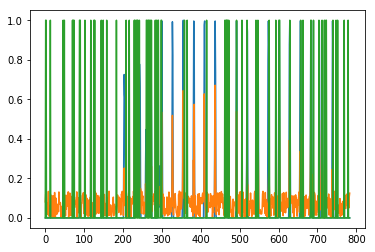

In [92]:
plt.plot(x_test)
plt.plot(x_noise)
print np.mean(x_test), np.mean(x_noise)
plt.plot(np.random.binomial(1,x_noise))

In [64]:
np.where(np.random.multinomial(1, np.ones(28)/28) == 1)[0][0]

23